### Project Chicago: Transform ResStock PACKAGE Results to 15 SFD prototypes (Elevate Energy)
Created on: 01/07/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [8]:
# local path to downloaded results
iteration = '02_2019' # <----- options: 02, 02_2018, 02_2019
iter_path = f'cookcnty_packages_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir, iter_path)

# accessory file path (for adding to package iteration)
acc_iter_path = f'cookcnty_upgrades_02'
acc_path = os.path.join(result_dir, acc_iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Results path: \n   {result_path}')
print(f'Accessory files path: \n   {acc_path}')


Results path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2019
Accessory files path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_02


### Functions

In [9]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui', 'elec_eui', 'site_eui'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui','elec_eui','site_eui']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
    
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')

def load_upgrade(n, file_dir=result_path):
    """
    ARG:
        n (int, str): upgrade number
        file_dir (str): folder in which upgrade can be found, default to main result dir
    RETURN:
        df (dataframe) of upgrade n
    """
    df = pd.read_parquet(os.path.join(file_dir,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    return df
print('func loaded: "load_upgrade"')



func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"
func loaded: "load_upgrade"


### 1. BASELINE results

In [10]:
save_a_copy_in_csv = False # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)

if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)
    
# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
jobs_missing = set(range(1,246)) - set(res.job_id.unique())
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {16777-len(res)} buildings ({((16777-len(res))/16777*100):.2f}%)')

res

- 0 jobs missing: set()
- 0 buildings (0.00%)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui
0,1,182,2021-02-17 08:16:01,2021-02-17 08:17:29,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.181818,18.727273,22.533039,18.269324,4770.0,24.282407,885.0,1.078182,11.405646,146.710210
1,2,88,2021-02-17 05:58:42,2021-02-17 06:00:22,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.818182,18.454545,16.018383,8.847772,4383.0,16.795563,3301.0,0.427774,3.051162,53.178209
2,3,234,2021-02-17 09:42:17,2021-02-17 09:43:45,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.818182,17.909091,12.939766,9.504607,4674.0,14.163515,1690.0,0.639422,4.364434,78.819067
3,4,48,2021-02-17 11:25:13,2021-02-17 11:26:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.727273,18.545455,11.782898,9.975689,4938.0,13.042851,2176.0,0.544576,4.739093,70.615114
4,5,240,2021-02-17 14:38:48,2021-02-17 14:40:10,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.272727,12.909091,16.977178,27.114971,701.0,29.936947,1690.0,0.000000,11.190095,38.182158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,31,2021-02-17 06:55:25,2021-02-17 06:56:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.181818,14.909091,27.370968,21.037212,5268.0,31.145534,2176.0,0.723052,4.178013,86.543934
16773,16774,192,2021-02-17 09:35:26,2021-02-17 09:36:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.636364,17.363636,17.516960,11.891985,4648.0,20.075483,1220.0,1.626523,8.651990,192.135301
16774,16775,98,2021-02-17 06:33:21,2021-02-17 06:34:45,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.454545,16.181818,16.722641,8.270191,4263.0,17.744540,1690.0,1.271651,5.012248,144.237237
16775,16776,181,2021-02-17 11:48:35,2021-02-17 11:50:13,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.181818,18.363636,31.551069,12.506351,5153.0,32.857234,8194.0,0.415745,2.278459,49.338978


In [5]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [44]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_packages_02_2018 - BASELINE result summary:

  * 16753 / 16777 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.669134
2            0.305199
3            0.025667
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.544858
WoodStud     0.455142
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.357548
1960-79      0.265147
1980-99      0.100937
2000-09      0.044589
2010s        0.006447
<1940        0.225333
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.828687
Heat Pump      0.006029
None           0.010923
Room AC        0.154360
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASH

### 1.2. Add additional metrics to Baseline

In [7]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,vintage_ee,stories
0,1,102,2021-02-05 02:24:37,2021-02-05 02:26:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.471283,14.896625,4697.0,20.325657,885.0,1.148540,11.165652,152.925378,2: 1942-1978,1: <2 stories
1,2,48,2021-02-05 07:19:03,2021-02-05 07:20:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.123814,9.113648,4793.0,16.834492,3301.0,0.458179,3.037822,56.172487,3: post-1978,2: 2+ stories
2,3,186,2021-02-05 05:22:33,2021-02-05 05:23:58,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.044362,11.013505,4742.0,17.919365,1690.0,0.679667,4.270627,82.522438,3: post-1978,2: 2+ stories
3,4,144,2021-02-05 07:16:06,2021-02-05 07:17:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,10.888104,9.437969,4747.0,11.565471,2176.0,0.577075,4.668017,73.621638,2: 1942-1978,1: <2 stories
4,5,14,2021-02-05 04:50:38,2021-02-05 04:52:00,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.534783,29.826604,618.0,32.951464,1690.0,0.000000,11.628206,39.677054,3: post-1978,1: <2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,238,2021-02-05 01:59:38,2021-02-05 02:01:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,27.121860,18.715424,5176.0,30.142275,2176.0,0.770269,4.137318,91.125608,1: pre-1942,2: 2+ stories
16773,16774,62,2021-02-05 01:38:19,2021-02-05 01:39:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.477228,12.475251,4743.0,21.115732,1220.0,1.701435,8.439115,198.898373,1: pre-1942,2: 2+ stories
16774,16775,130,2021-02-05 01:08:12,2021-02-05 01:09:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.113838,7.591218,3591.0,16.801541,1690.0,1.358084,4.786245,152.107395,1: pre-1942,2: 2+ stories
16775,16776,110,2021-02-05 03:14:46,2021-02-05 03:16:23,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,30.521646,13.541342,4982.0,32.179126,8194.0,0.444241,2.095281,51.562877,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [18]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [9]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [10]:
res2 = []

for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        res_group_i['prototype'] = row['HousingGroupName']
        res2.append(res_group_i)

res2 = pd.concat(res2, axis=0).sort_values(by=['building_id'])
display(res2)

res2 = res2.set_index('building_id').reindex(res['building_id']).reset_index()
res.loc[res2['prototype'].isnull(),:]

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,vintage_ee,stories,prototype
0,1,102,2021-02-05 02:24:37,2021-02-05 02:26:01,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.896625,4697.0,20.325657,885.0,1.148540,11.165652,152.925378,2: 1942-1978,1: <2 stories,Masonry 1942-1978 Less than 2 Stories
1,2,48,2021-02-05 07:19:03,2021-02-05 07:20:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.113648,4793.0,16.834492,3301.0,0.458179,3.037822,56.172487,3: post-1978,2: 2+ stories,Masonry Post-1978 2 or more stories
2,3,186,2021-02-05 05:22:33,2021-02-05 05:23:58,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,11.013505,4742.0,17.919365,1690.0,0.679667,4.270627,82.522438,3: post-1978,2: 2+ stories,Frame Post-1978 2 or more stories
3,4,144,2021-02-05 07:16:06,2021-02-05 07:17:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.437969,4747.0,11.565471,2176.0,0.577075,4.668017,73.621638,2: 1942-1978,1: <2 stories,Frame 1942-1978 less than 2 stories
4,5,14,2021-02-05 04:50:38,2021-02-05 04:52:00,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,29.826604,618.0,32.951464,1690.0,0.000000,11.628206,39.677054,3: post-1978,1: <2 stories,Frame Post-1978 Less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,238,2021-02-05 01:59:38,2021-02-05 02:01:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.715424,5176.0,30.142275,2176.0,0.770269,4.137318,91.125608,1: pre-1942,2: 2+ stories,Frame Pre-1942 2 or more stories
16773,16774,62,2021-02-05 01:38:19,2021-02-05 01:39:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.475251,4743.0,21.115732,1220.0,1.701435,8.439115,198.898373,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories
16774,16775,130,2021-02-05 01:08:12,2021-02-05 01:09:37,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,7.591218,3591.0,16.801541,1690.0,1.358084,4.786245,152.107395,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories
16775,16776,110,2021-02-05 03:14:46,2021-02-05 03:16:23,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,13.541342,4982.0,32.179126,8194.0,0.444241,2.095281,51.562877,1: pre-1942,2: 2+ stories,Masonry Pre-1942 2 or more stories


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,vintage_ee,stories
444,445,159,2021-02-05 04:07:03,2021-02-05 04:07:38,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
1955,1956,105,2021-02-05 06:10:07,2021-02-05 06:10:37,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
2407,2408,186,2021-02-05 01:26:03,2021-02-05 01:26:36,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
2520,2521,134,2021-02-05 02:55:36,2021-02-05 02:56:05,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
2862,2863,98,2021-02-05 01:14:21,2021-02-05 01:14:53,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
3509,3510,86,2021-02-05 04:20:41,2021-02-05 04:21:12,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
4281,4282,12,2021-02-05 04:00:11,2021-02-05 04:00:40,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
4372,4373,171,2021-02-05 07:39:06,2021-02-05 07:39:37,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
4957,4958,83,2021-02-05 04:11:40,2021-02-05 04:12:10,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories
5026,5027,36,2021-02-05 02:29:24,2021-02-05 02:29:55,Fail,None,None,,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3: post-1978,2: 2+ stories


In [11]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [12]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2394.582482,812.925928,894.776148,0.405010,0.437646,8454.417739,9489.239626,4.035888,4.673625
2,Masonry All Years Split Level,1690.0,2000.196867,1160.162677,1284.790414,0.693078,0.735932,8615.090569,9980.655717,5.056944,5.833192
3,Masonry Post-1978 2 or more stories,3301.0,4058.270428,1329.090503,1360.947193,0.387624,0.417770,11118.274898,13035.958459,3.385613,3.860405
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1680.132653,1041.597499,1136.148776,0.689687,0.723602,8145.186740,9195.569872,5.272116,6.023757
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1583.514335,1668.756536,0.758375,0.785355,9741.030493,11408.176432,4.644163,5.537005
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.060606,1360.578761,1432.380214,1.014578,1.061201,8247.039899,9338.014003,6.312005,6.989444
7,Masonry Pre-1942 2 or more stories,2176.0,2552.909881,1820.512232,1970.720051,0.872440,0.909810,10239.710968,12595.044382,4.877059,6.004990
8,Frame Post-1978 Less than 2 stories,2176.0,2243.300336,859.103060,937.391292,0.455442,0.480803,8350.641713,9475.856850,4.366193,4.945080
9,Frame Post-1978 Split Level,2176.0,3012.053452,1093.283394,1218.764502,0.466412,0.484156,9378.751814,11310.788906,3.855301,4.538597


In [13]:
### export BASELINE prototype summary
groups.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/baseline


## 2A. PACKAGE post processing ###
Three packages were ran as partitioned files. See "Cookcnty_packages_02.yml" for info
#### (1) Packages WITHOUT partitions (N=1, pkg 06)

In [45]:
def check_and_correct_for_missing_buildings(Pi, res, upgrade_no):
    delta = len(res)-len(Pi)
    if delta>0:
        print(f'   - upgrade_{upgrade_no:02d} is missing {delta} buildings compared to baseline')
    # always reindex
    Pi = Pi.set_index('building_id').reindex(res['building_id']).reset_index()
        
    return Pi

'func "check_and_correct_for_missing_buildings" loaded'

'func "check_and_correct_for_missing_buildings" loaded'

In [46]:
### (1) 
upgrade_list = [1,]
package_numbers = [6,]

print(f'packages without partitions: {len(upgrade_list)}')

for up, pk in zip(upgrade_list, package_numbers):
    file = f'package{pk:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}')

    if os.path.exists(filename):
        Pi = pd.read_csv(filename)

    else:
        Pi = load_upgrade(up, result_path)
        Pi = check_and_correct_for_missing_buildings(Pi, res, up)

        ## (3) save
        Pi.to_csv(filename, index=False)
    display(Pi)
    
print(f'\n>> file saved to: {combined_res_csv_path}')

packages without partitions: 1
* package06.csv


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario
0,1,95,2021-02-14 03:03:27,2021-02-14 03:03:49,Fail,NaN,NaN,
1,2,16,2021-02-14 02:20:48,2021-02-14 02:21:10,Fail,NaN,NaN,
2,3,135,2021-02-14 03:57:00,2021-02-14 03:57:22,Fail,NaN,NaN,
3,4,106,2021-02-14 03:25:24,2021-02-14 03:25:47,Fail,NaN,NaN,
4,5,6,2021-02-14 02:14:08,2021-02-14 02:14:29,Fail,NaN,NaN,
...,...,...,...,...,...,...,...,...
16772,16773,134,2021-02-14 03:32:15,2021-02-14 03:32:39,Fail,NaN,NaN,
16773,16774,179,2021-02-14 05:46:18,2021-02-14 05:46:41,Fail,NaN,NaN,
16774,16775,216,2021-02-14 06:27:27,2021-02-14 06:27:51,Fail,NaN,NaN,
16775,16776,187,2021-02-14 06:32:25,2021-02-14 06:32:49,Fail,NaN,NaN,



>> file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


#### (2) Packages WITH single-level partitions (N=10, pkg 07-16)

In [47]:
# 2 partitiions over 'Attic Insulation'

def combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                           MSHP_option=None, save_as_csv=True, recreate_from_scratch=True):
    global res
    """
    ARGS:
        pkg_no (int): package number to assign to combined df
        upgrade_list (list): list of ResStock upgrades to combine
        partition_para (str): para to filter the upgrades by and combine
        options_list_for_first_upgrades (list of list): list of para options to filter the first n-1 upgrades by
        MSHP_option (int): option number in package to correct, default to None
        save_as_csv (bool): default to True
        recreate_from_scratch (bool): default to True
    
    RETURN:
        P1: combined df
    """
    file = f'package{pkg_no:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}, from upgrades: {upgrade_list}')
    
    N = len(upgrade_list)
    partition_para = f'build_existing_model.{partition_para}'
    
    # check setting:
    if N-1 != len(options_list_for_first_upgrades):
        raise ValueError(f'The size of "options_list_for_first_upgrades" = {len(options_list_for_first_upgrades)}, '+
                         f'is not 1 less than the size of "upgrade_list" = {N}')

    if not os.path.exists(filename) or recreate_from_scratch:
        print(f'building from resstock results... partitioned by:\n  "{partition_para}"')

        ## (1) building ids for each partitions based on partition_para and para_options
        bldg_list = options_list = []; msg = ' '; n_bldgs = 0
        for n in range(N-1):
            bldgs_for_part_n = res[res[partition_para].isin(options_list_for_first_upgrades[n])]['building_id']
            bldg_list.append(bldgs_for_part_n)
            
            options_for_part_n = options_list_for_first_upgrades[n]
            options_list = options_list + options_for_part_n
            
            n_bldgs += len(bldgs_for_part_n)
            msg += f' part {n+1}: {len(bldgs_for_part_n)},'
        
        # for last partition:
        bldgs_for_part_n = res[~res[partition_para].isin(options_list)]['building_id']
        bldg_list.append(bldgs_for_part_n)
        
        n_bldgs += len(bldgs_for_part_n)
        msg += f' part {N}: {len(bldgs_for_part_n)}, total: {n_bldgs}'
        print(msg)

        ## (2) combine partitions and update upgrade name
        P1 = []
        for up, Bi in zip(upgrade_list, bldg_list):
            p = load_upgrade(up, result_path)
            p = check_and_correct_for_missing_buildings(p, res, up)
            P1.append(p[p['building_id'].isin(Bi)])

        P1 = pd.concat(P1, axis=0).sort_index()

        P1['apply_upgrade.upgrade_part'] = P1['apply_upgrade.upgrade_name'] # new col to show partition #
        P1['apply_upgrade.upgrade_name'] = P1['apply_upgrade.upgrade_name'].apply(
            lambda x: ' '.join(str(x).split(' ')[:-3])) # update name
        
        ## (3) correct MSHP costs
        if not MSHP_option == None:
            print('\nrecalculating MSHP cost...')
            MSHP_cost = f'simulation_output_report.option_{MSHP_option:02d}_cost_usd'
            
            # rename orig upgrade_cost col
            if not 'simulation_output_report.upgrade_cost_usd_orig' in P1.columns:
                P1['simulation_output_report.upgrade_cost_usd_orig'] = P1['simulation_output_report.upgrade_cost_usd']

            # copy upgrade_cost col
            P1['simulation_output_report.upgrade_cost_usd'] = P1['simulation_output_report.upgrade_cost_usd_orig']

            # remove old MSHP cost
            P1['simulation_output_report.upgrade_cost_usd'] -= P1[MSHP_cost]

            # recalc upgrade costs for MSHP
            idx = (P1['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
            P1.loc[idx, MSHP_cost] = \
                710 + (95+1800/12)*P1.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

            # calculate backup heating system size and cost
            supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
            P1['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
            P1.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
                P1.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

            P1['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
                supp_heat_cost * P1.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

            # add new MSHP and backup heat cost to 'upgrade_cost_usd'
            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P1.loc[idx, MSHP_cost]

            P1.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P1.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']

            # show
            print(f'>> package={pkg_no:02d} modified cols:')
            display(P1.loc[idx, ['apply_upgrade.upgrade_name',
                                'simulation_output_report.upgrade_cost_usd_orig',
                                'simulation_output_report.upgrade_cost_usd', # updated
                                'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                                'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                               ]])
        
        ## (4) save
        if save_as_csv:
            print(f'\n>> combined file saved to: {combined_res_csv_path}')
            P1.to_csv(filename, index=False)
            
    else:
        P1 = pd.read_csv(filename)

#     display(P1)
    return P1

print('func "combine_df_from_two_partitions"')


func "combine_df_from_two_partitions"


In [48]:
pkg_no = 7
upgrade_list = [2, 3]
partition_para = 'insulation_unfinished_attic'
options_list_for_first_upgrades = [
    ['Uninsulated, Vented','Ceiling R-7, Vented','Ceiling R-13, Vented'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package07.csv, from upgrades: [2, 3]
building from resstock results... partitioned by:
  "build_existing_model.insulation_unfinished_attic"
  part 1: 5228, part 2: 11549, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,231,2021-02-14 06:56:01,2021-02-14 06:56:24,Fail,NaN,,,NaN
1,2,13,2021-02-14 01:22:35,2021-02-14 01:23:00,Fail,NaN,,,NaN
2,3,210,2021-02-14 06:56:20,2021-02-14 06:56:44,Fail,NaN,,,NaN
3,4,174,2021-02-14 06:49:33,2021-02-14 06:49:54,Fail,NaN,,,NaN
4,5,201,2021-02-14 06:54:53,2021-02-14 06:55:16,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,130,2021-02-14 03:27:18,2021-02-14 03:27:42,Fail,NaN,,,NaN
16773,16774,182,2021-02-14 06:51:24,2021-02-14 06:51:50,Fail,NaN,,,NaN
16774,16775,59,2021-02-14 03:05:56,2021-02-14 03:06:20,Fail,NaN,,,NaN
16775,16776,173,2021-02-14 06:13:34,2021-02-14 06:13:59,Fail,NaN,,,NaN


In [49]:
pkg_no = 8
upgrade_list = [4, 5]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package08.csv, from upgrades: [4, 5]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,107,2021-02-14 02:54:19,2021-02-14 02:54:42,Fail,NaN,,,NaN
1,2,244,2021-02-14 06:34:31,2021-02-14 06:34:53,Fail,NaN,,,NaN
2,3,14,2021-02-14 02:09:40,2021-02-14 02:10:06,Fail,NaN,,,NaN
3,4,242,2021-02-14 06:52:11,2021-02-14 06:52:36,Fail,NaN,,,NaN
4,5,198,2021-02-14 06:32:39,2021-02-14 06:33:01,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,144,2021-02-14 03:16:20,2021-02-14 03:16:44,Fail,NaN,,,NaN
16773,16774,9,2021-02-14 00:55:23,2021-02-14 00:55:47,Fail,NaN,,,NaN
16774,16775,156,2021-02-14 05:57:49,2021-02-14 05:58:14,Fail,NaN,,,NaN
16775,16776,109,2021-02-14 03:31:40,2021-02-14 03:32:04,Fail,NaN,,,NaN


In [50]:
pkg_no = 9
upgrade_list = [6, 7]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package09.csv, from upgrades: [6, 7]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,149,2021-02-14 06:20:49,2021-02-14 06:21:11,Fail,NaN,,,NaN
1,2,4,2021-02-14 01:00:42,2021-02-14 01:01:05,Fail,NaN,,,NaN
2,3,230,2021-02-14 06:13:37,2021-02-14 06:14:01,Fail,NaN,,,NaN
3,4,202,2021-02-14 05:55:25,2021-02-14 05:55:47,Fail,NaN,,,NaN
4,5,94,2021-02-14 04:00:00,2021-02-14 04:00:21,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,172,2021-02-14 05:53:12,2021-02-14 05:53:36,Fail,NaN,,,NaN
16773,16774,85,2021-02-14 02:54:05,2021-02-14 02:54:29,Fail,NaN,,,NaN
16774,16775,146,2021-02-14 03:27:30,2021-02-14 03:27:54,Fail,NaN,,,NaN
16775,16776,209,2021-02-14 06:51:42,2021-02-14 06:52:07,Fail,NaN,,,NaN


In [51]:
pkg_no = 10
upgrade_list = [8, 9]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package10.csv, from upgrades: [8, 9]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,241,2021-02-14 06:10:41,2021-02-14 06:11:06,Fail,NaN,,,NaN
1,2,100,2021-02-14 04:08:15,2021-02-14 04:08:38,Fail,NaN,,,NaN
2,3,71,2021-02-14 03:50:41,2021-02-14 03:51:02,Fail,NaN,,,NaN
3,4,240,2021-02-14 07:21:54,2021-02-14 07:22:16,Fail,NaN,,,NaN
4,5,139,2021-02-14 02:58:38,2021-02-14 02:59:00,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,83,2021-02-14 03:25:13,2021-02-14 03:25:37,Fail,NaN,,,NaN
16773,16774,160,2021-02-14 05:42:42,2021-02-14 05:43:05,Fail,NaN,,,NaN
16774,16775,176,2021-02-14 06:43:38,2021-02-14 06:44:06,Fail,NaN,,,NaN
16775,16776,149,2021-02-14 06:57:25,2021-02-14 06:57:51,Fail,NaN,,,NaN


In [52]:
pkg_no = 11
upgrade_list = [10, 11]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package11.csv, from upgrades: [10, 11]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,190,2021-02-14 06:34:28,2021-02-14 06:34:53,Fail,NaN,,,NaN
1,2,68,2021-02-14 03:02:14,2021-02-14 03:02:36,Fail,NaN,,,NaN
2,3,113,2021-02-14 03:34:33,2021-02-14 03:34:54,Fail,NaN,,,NaN
3,4,166,2021-02-14 05:54:26,2021-02-14 05:54:48,Fail,NaN,,,NaN
4,5,101,2021-02-14 03:10:55,2021-02-14 03:11:19,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,17,2021-02-14 02:26:14,2021-02-14 02:26:39,Fail,NaN,,,NaN
16773,16774,158,2021-02-14 06:26:32,2021-02-14 06:26:56,Fail,NaN,,,NaN
16774,16775,121,2021-02-14 02:53:52,2021-02-14 02:54:16,Fail,NaN,,,NaN
16775,16776,130,2021-02-14 02:48:16,2021-02-14 02:48:40,Fail,NaN,,,NaN


In [53]:
pkg_no = 12
upgrade_list = [12, 13, 14]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50'],
    ['10 ACH50','8 ACH50','7 ACH50','6 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package12.csv, from upgrades: [12, 13, 14]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 12292, part 2: 3575, part 3: 910, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,17,2021-02-14 01:23:25,2021-02-14 01:23:47,Fail,NaN,,,NaN
1,2,199,2021-02-14 06:16:46,2021-02-14 06:17:10,Fail,NaN,,,NaN
2,3,163,2021-02-14 06:23:02,2021-02-14 06:23:24,Fail,NaN,,,NaN
3,4,144,2021-02-14 03:22:33,2021-02-14 03:22:56,Fail,NaN,,,NaN
4,5,68,2021-02-14 03:42:37,2021-02-14 03:43:00,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,225,2021-02-14 06:52:04,2021-02-14 06:52:31,Fail,NaN,,,NaN
16773,16774,12,2021-02-14 01:26:34,2021-02-14 01:26:58,Fail,NaN,,,NaN
16774,16775,101,2021-02-14 03:28:13,2021-02-14 03:28:37,Fail,NaN,,,NaN
16775,16776,202,2021-02-14 05:52:08,2021-02-14 05:52:32,Fail,NaN,,,NaN


In [54]:
pkg_no = 13
upgrade_list = [15, 16]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package13.csv, from upgrades: [15, 16]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,214,2021-02-14 06:10:36,2021-02-14 06:11:00,Fail,NaN,,,NaN
1,2,183,2021-02-14 06:33:53,2021-02-14 06:34:15,Fail,NaN,,,NaN
2,3,26,2021-02-14 01:22:42,2021-02-14 01:23:07,Fail,NaN,,,NaN
3,4,88,2021-02-14 03:51:27,2021-02-14 03:51:52,Fail,NaN,,,NaN
4,5,68,2021-02-14 03:20:22,2021-02-14 03:20:45,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,77,2021-02-14 03:33:12,2021-02-14 03:33:37,Fail,NaN,,,NaN
16773,16774,133,2021-02-14 02:55:50,2021-02-14 02:56:14,Fail,NaN,,,NaN
16774,16775,24,2021-02-14 02:41:45,2021-02-14 02:42:09,Fail,NaN,,,NaN
16775,16776,81,2021-02-14 03:32:18,2021-02-14 03:32:44,Fail,NaN,,,NaN


In [55]:
pkg_no = 14
upgrade_list = [17, 18, 19, 20]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50'],
    ['20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
    ['7 ACH50','6 ACH50','5 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)



* package14.csv, from upgrades: [17, 18, 19, 20]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 5216, part 2: 9510, part 3: 1508, part 4: 543, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,94,2021-02-14 03:45:52,2021-02-14 03:46:13,Fail,NaN,,,NaN
1,2,180,2021-02-14 06:43:03,2021-02-14 06:43:26,Fail,NaN,,,NaN
2,3,31,2021-02-14 02:32:48,2021-02-14 02:33:11,Fail,NaN,,,NaN
3,4,186,2021-02-14 06:42:19,2021-02-14 06:42:43,Fail,NaN,,,NaN
4,5,217,2021-02-14 05:55:49,2021-02-14 05:56:11,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,102,2021-02-14 04:03:32,2021-02-14 04:03:56,Fail,NaN,,,NaN
16773,16774,181,2021-02-14 06:57:11,2021-02-14 06:57:34,Fail,NaN,,,NaN
16774,16775,31,2021-02-14 02:36:56,2021-02-14 02:37:20,Fail,NaN,,,NaN
16775,16776,42,2021-02-14 03:26:45,2021-02-14 03:27:12,Fail,NaN,,,NaN


In [56]:
pkg_no = 15
upgrade_list = [21, 22]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package15.csv, from upgrades: [21, 22]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,220,2021-02-14 06:34:55,2021-02-14 06:35:17,Fail,NaN,,,NaN
1,2,184,2021-02-14 06:56:01,2021-02-14 06:56:23,Fail,NaN,,,NaN
2,3,105,2021-02-14 03:26:41,2021-02-14 03:27:05,Fail,NaN,,,NaN
3,4,206,2021-02-14 07:13:39,2021-02-14 07:14:00,Fail,NaN,,,NaN
4,5,179,2021-02-14 06:45:51,2021-02-14 06:46:16,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,181,2021-02-14 06:39:35,2021-02-14 06:40:00,Fail,NaN,,,NaN
16773,16774,23,2021-02-14 01:31:40,2021-02-14 01:32:05,Fail,NaN,,,NaN
16774,16775,18,2021-02-14 02:02:30,2021-02-14 02:02:57,Fail,NaN,,,NaN
16775,16776,61,2021-02-14 02:49:57,2021-02-14 02:50:23,Fail,NaN,,,NaN


In [57]:
pkg_no = 16
upgrade_list = [23, 24]
partition_para = 'infiltration'
options_list_for_first_upgrades = [
    ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50'],
]
MSHP_option = None #4

combine_df_from_first_level_partitions(pkg_no, upgrade_list, partition_para, options_list_for_first_upgrades, 
                                       MSHP_option, save_as_csv=True, recreate_from_scratch=True)


* package16.csv, from upgrades: [23, 24]
building from resstock results... partitioned by:
  "build_existing_model.infiltration"
  part 1: 14726, part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02_2018/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,29,2021-02-14 01:22:10,2021-02-14 01:22:32,Fail,NaN,,,NaN
1,2,110,2021-02-14 03:09:01,2021-02-14 03:09:26,Fail,NaN,,,NaN
2,3,17,2021-02-14 01:19:50,2021-02-14 01:20:12,Fail,NaN,,,NaN
3,4,177,2021-02-14 06:08:03,2021-02-14 06:08:27,Fail,NaN,,,NaN
4,5,166,2021-02-14 06:19:21,2021-02-14 06:19:43,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,84,2021-02-14 03:35:03,2021-02-14 03:35:26,Fail,NaN,,,NaN
16773,16774,50,2021-02-14 03:27:01,2021-02-14 03:27:25,Fail,NaN,,,NaN
16774,16775,120,2021-02-14 02:48:06,2021-02-14 02:48:31,Fail,NaN,,,NaN
16775,16776,18,2021-02-14 02:40:37,2021-02-14 02:41:01,Fail,NaN,,,NaN


#### (3) Packages WITH multi-level partitions (N=4, pkg 17-20)

In [61]:
def combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option=None, 
                                         fix_upgrade_name=False, save_as_csv=True, recreate_from_scratch=True):
    global res
    """
    ARGS:
        pkg_no (int): package number to assign to combined df
        upgrade_list (list): list of ResStock upgrades to combine
        level1_list (list of dict): list of dictionaries defining the level 1 partition key and options
        level2_list (list of dict): list of dictionaries defining the level 2 partition key and options
        MSHP_option (int): option number in package to correct, default to None
        fix_upgrade_name (bool): default to True, for pkg 21-24 only
        save_as_csv (bool): default to True
        recreate_from_scratch (bool): default to True
    
    RETURN:
        P1: combined df
    """
    
    file = f'package{pkg_no:02d}.csv'
    filename = os.path.join(combined_res_csv_path, file)
    print(f'* {file}, from upgrades: {upgrade_list}')
    
    N_upgrades = len(upgrade_list)
    N_partitions = len(level1_list)*len(level2_list)
    if N_upgrades != N_partitions:
        raise ValueError(f'The size of "upgrade_list" = {N_upgrades} does not match the number of enumeration from '+
                        f'"level1_list" and "level2_list" = {N_partitions}')
    
    if not os.path.exists(filename) or recreate_from_scratch:
        
        print(f'building from resstock run results, {N_partitions} partitions...\n')

        ## building ids for each partitions
        bldg_list = []; CBi_len = 0

        ##### level 1
        P4C1 = level1_list # <----
        for i , Ci in enumerate(P4C1,1):
            CBi = set()
            for key, lst in Ci.items():
                Bi = res[res[f'build_existing_model.{key}'].replace({np.nan:'None'}).isin(lst)]['building_id']
                CBi = CBi.union(set(list(Bi)))
                print(f'- 1.{i} {key}, {len(Bi)} / {len(res)}')
            print(f'- 1.{i} total, {len(CBi)}')
            res1 = res[res[f'building_id'].isin(CBi)]

            ##### level 2
            P4C2 = level2_list # <----
            CBi_2all = set(); CBi_2len = 0
            for k, Ci in enumerate(P4C2,1):
                if k == len(P4C2):
                    CBi = set(list(res1['building_id'])).difference(CBi_2all)
                    print(f'    + 3.{k} total, {len(CBi)}')
                else:
                    CBi = set()
                    for key, lst in Ci.items():
                        Bi = res1[res1[f'build_existing_model.{key}'].isin(lst)]['building_id']
                        CBi = CBi.union(set(list(Bi)))
                        print(f'    + 3.{k} {key}, {len(Bi)} / {len(res1)}')
                CBi_2all = CBi_2all.union(CBi)
                bldg_list.append(CBi)

                CBi_2len += len(CBi)
                CBi_len += len(CBi)
                print(f'appending total {len(CBi)}, (1.{i})(2.{k})_culm = {CBi_2len}, overall_culm = {CBi_len}\n')

        ## (2) combine partitions, update upgrade name
        P4 = []
        for up, Bi in zip(upgrade_list, bldg_list):
            p = load_upgrade(up, result_path)
            p = check_and_correct_for_missing_buildings(p, res, up)
            P4.append(p[p['building_id'].isin(Bi)])

        P4 = pd.concat(P4, axis=0).sort_index()

        P4['apply_upgrade.upgrade_part'] = P4['apply_upgrade.upgrade_name'] # new col to show partition #
        P4['apply_upgrade.upgrade_name'] = P4['apply_upgrade.upgrade_name'].apply(
            lambda x: ' '.join(str(x).split(' ')[:-3])) # update name
        
        ## (3) correct MSHP costs
        if not MSHP_option == None:
            print('\nrecalculating MSHP cost...')
            MSHP_cost = f'simulation_output_report.option_{MSHP_option:02d}_cost_usd'
            
            # rename orig upgrade_cost col
            if not 'simulation_output_report.upgrade_cost_usd_orig' in P4.columns:
                P4['simulation_output_report.upgrade_cost_usd_orig'] = P4['simulation_output_report.upgrade_cost_usd']

            # copy upgrade_cost col
            P4['simulation_output_report.upgrade_cost_usd'] = P4['simulation_output_report.upgrade_cost_usd_orig']

            # remove old MSHP cost
            P4['simulation_output_report.upgrade_cost_usd'] -= P4[MSHP_cost]

            # recalc upgrade costs for MSHP
            idx = (P4['simulation_output_report.applicable']==True) & (res['build_existing_model.hvac_has_ducts']=='No')
            P4.loc[idx, MSHP_cost] = \
                710 + (95+1800/12)*P4.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

            # calculate backup heating system size and cost
            supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
            P4['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
            P4.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
                P4.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

            P4['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
                supp_heat_cost * P4.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

            # add new MSHP and backup heat cost to 'upgrade_cost_usd'
            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P4.loc[idx, MSHP_cost]

            P4.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
                P4.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']

            # show
            print(f'>> package={pkg_no:02d} modified cols:')
            display(P4.loc[idx, ['apply_upgrade.upgrade_name',
                                'simulation_output_report.upgrade_cost_usd_orig',
                                'simulation_output_report.upgrade_cost_usd', # updated
                                'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                                'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                               ]])
            
        ## (5) fix upgrade name
        try:
            P4[['apply_upgrade.upgrade_name','apply_upgrade.upgrade_part']] = \
                P4[['apply_upgrade.upgrade_name','apply_upgrade.upgrade_part']].apply(
                lambda x: x.str.replace('low-E Window','Low-Gain Window')) # fix upgrade name
        except:
            pass

        ## (5) save
        P4.to_csv(filename, index=False)

    else:              
        P4 = pd.read_csv(filename)
    
    return P4

print('func "combine_df_from_two_level_partitions" loaded')

func "combine_df_from_two_level_partitions" loaded


In [62]:
pkg_no = 17 # <----
upgrade_list = list(range(25, 25+8)) # <----
MSHP_option = None 
fix_upgrade_name = False
    
## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package17.csv, from upgrades: [25, 26, 27, 28, 29, 30, 31, 32]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 2034 / 5216
appending total 2034, (1.1)(2.1)_culm = 2034, overall_culm = 2034

    + 3.2 total, 3182
appending total 3182, (1.1)(2.2)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 2701 / 9510
appending total 2701, (1.2)(2.1)_culm = 2701, overall_culm = 7917

    + 3.2 total, 6809
appending total 6809, (1.2)(2.2)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 428 / 1508
appending total 428, (1.3)(2.1)_culm = 428, overall_culm = 15154

    + 3.2 total, 1080
appending total 1080, (1.3)(2.2)_culm = 1508, overall_culm = 16234

- 1.4 infiltration, 543 / 16777
- 1.4 total, 543
    + 3.1 insulation_unfinished_attic, 65 / 543
appending t

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,108,2021-02-14 03:44:58,2021-02-14 03:45:20,Fail,NaN,,,NaN
1,2,212,2021-02-14 07:02:10,2021-02-14 07:02:32,Fail,NaN,,,NaN
2,3,201,2021-02-14 06:28:30,2021-02-14 06:28:54,Fail,NaN,,,NaN
3,4,242,2021-02-14 06:49:41,2021-02-14 06:50:03,Fail,NaN,,,NaN
4,5,127,2021-02-14 02:52:03,2021-02-14 02:52:28,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,135,2021-02-14 03:09:41,2021-02-14 03:10:07,Fail,NaN,,,NaN
16773,16774,14,2021-02-14 02:02:06,2021-02-14 02:02:31,Fail,NaN,,,NaN
16774,16775,176,2021-02-14 06:02:48,2021-02-14 06:03:14,Fail,NaN,,,NaN
16775,16776,9,2021-02-14 01:31:09,2021-02-14 01:31:32,Fail,NaN,,,NaN


In [63]:
pkg_no = 18 # <----
upgrade_list = list(range(33, 33+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package18.csv, from upgrades: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 1385 / 5216
appending total 1385, (1.1)(2.1)_culm = 1385, overall_culm = 1385

    + 3.2 insulation_unfinished_attic, 1749 / 5216
appending total 1749, (1.1)(2.2)_culm = 3134, overall_culm = 3134

    + 3.3 total, 2082
appending total 2082, (1.1)(2.3)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 1549 / 9510
appending total 1549, (1.2)(2.1)_culm = 1549, overall_culm = 6765

    + 3.2 insulation_unfinished_attic, 3314 / 9510
appending total 3314, (1.2)(2.2)_culm = 4863, overall_culm = 10079

    + 3.3 total, 4647
appending total 4647, (1.2)(2.3)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 291 / 1508
appending 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,229,2021-02-14 06:39:33,2021-02-14 06:39:54,Fail,NaN,,,NaN
1,2,66,2021-02-14 02:29:52,2021-02-14 02:30:14,Fail,NaN,,,NaN
2,3,55,2021-02-14 03:14:45,2021-02-14 03:15:09,Fail,NaN,,,NaN
3,4,101,2021-02-14 03:09:37,2021-02-14 03:09:59,Fail,NaN,,,NaN
4,5,166,2021-02-14 05:54:27,2021-02-14 05:54:52,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,24,2021-02-14 01:50:50,2021-02-14 01:51:16,Fail,NaN,,,NaN
16773,16774,109,2021-02-14 02:46:02,2021-02-14 02:46:25,Fail,NaN,,,NaN
16774,16775,155,2021-02-14 07:02:03,2021-02-14 07:02:29,Fail,NaN,,,NaN
16775,16776,64,2021-02-14 02:43:01,2021-02-14 02:43:28,Fail,NaN,,,NaN


In [64]:
pkg_no = 19 # <----
upgrade_list = list(range(45, 45+8)) # <----
MSHP_option = None
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package19.csv, from upgrades: [45, 46, 47, 48, 49, 50, 51, 52]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 2034 / 5216
appending total 2034, (1.1)(2.1)_culm = 2034, overall_culm = 2034

    + 3.2 total, 3182
appending total 3182, (1.1)(2.2)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 2701 / 9510
appending total 2701, (1.2)(2.1)_culm = 2701, overall_culm = 7917

    + 3.2 total, 6809
appending total 6809, (1.2)(2.2)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 428 / 1508
appending total 428, (1.3)(2.1)_culm = 428, overall_culm = 15154

    + 3.2 total, 1080
appending total 1080, (1.3)(2.2)_culm = 1508, overall_culm = 16234

- 1.4 infiltration, 543 / 16777
- 1.4 total, 543
    + 3.1 insulation_unfinished_attic, 65 / 543
appending t

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,210,2021-02-14 07:20:14,2021-02-14 07:20:38,Fail,NaN,,,NaN
1,2,25,2021-02-14 02:42:10,2021-02-14 02:42:32,Fail,NaN,,,NaN
2,3,197,2021-02-14 06:38:38,2021-02-14 06:39:00,Fail,NaN,,,NaN
3,4,61,2021-02-14 02:39:17,2021-02-14 02:39:41,Fail,NaN,,,NaN
4,5,234,2021-02-14 06:58:48,2021-02-14 06:59:12,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,182,2021-02-14 06:31:22,2021-02-14 06:31:50,Fail,NaN,,,NaN
16773,16774,101,2021-02-14 04:07:14,2021-02-14 04:07:38,Fail,NaN,,,NaN
16774,16775,243,2021-02-14 06:49:27,2021-02-14 06:49:51,Fail,NaN,,,NaN
16775,16776,116,2021-02-14 02:56:40,2021-02-14 02:57:04,Fail,NaN,,,NaN


In [65]:
pkg_no = 20 # <----
upgrade_list = list(range(53, 53+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = False

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)



* package20.csv, from upgrades: [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 1385 / 5216
appending total 1385, (1.1)(2.1)_culm = 1385, overall_culm = 1385

    + 3.2 insulation_unfinished_attic, 1749 / 5216
appending total 1749, (1.1)(2.2)_culm = 3134, overall_culm = 3134

    + 3.3 total, 2082
appending total 2082, (1.1)(2.3)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 1549 / 9510
appending total 1549, (1.2)(2.1)_culm = 1549, overall_culm = 6765

    + 3.2 insulation_unfinished_attic, 3314 / 9510
appending total 3314, (1.2)(2.2)_culm = 4863, overall_culm = 10079

    + 3.3 total, 4647
appending total 4647, (1.2)(2.3)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 291 / 1508
appending 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,9,2021-02-14 01:46:07,2021-02-14 01:46:29,Fail,NaN,,,NaN
1,2,186,2021-02-14 06:10:37,2021-02-14 06:11:02,Fail,NaN,,,NaN
2,3,16,2021-02-14 01:59:36,2021-02-14 01:59:58,Fail,NaN,,,NaN
3,4,239,2021-02-14 06:03:28,2021-02-14 06:03:49,Fail,NaN,,,NaN
4,5,241,2021-02-14 06:27:23,2021-02-14 06:27:48,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,212,2021-02-14 06:47:50,2021-02-14 06:48:14,Fail,NaN,,,NaN
16773,16774,28,2021-02-14 02:25:55,2021-02-14 02:26:22,Fail,NaN,,,NaN
16774,16775,132,2021-02-14 03:16:11,2021-02-14 03:16:35,Fail,NaN,,,NaN
16775,16776,238,2021-02-14 06:59:49,2021-02-14 07:00:15,Fail,NaN,,,NaN


In [66]:
# with low-gain windows
pkg_no = 21 # <----
upgrade_list = list(range(65, 65+8)) # <----
MSHP_option = None 
fix_upgrade_name = True
    
## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)



* package21.csv, from upgrades: [65, 66, 67, 68, 69, 70, 71, 72]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 2034 / 5216
appending total 2034, (1.1)(2.1)_culm = 2034, overall_culm = 2034

    + 3.2 total, 3182
appending total 3182, (1.1)(2.2)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 2701 / 9510
appending total 2701, (1.2)(2.1)_culm = 2701, overall_culm = 7917

    + 3.2 total, 6809
appending total 6809, (1.2)(2.2)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 428 / 1508
appending total 428, (1.3)(2.1)_culm = 428, overall_culm = 15154

    + 3.2 total, 1080
appending total 1080, (1.3)(2.2)_culm = 1508, overall_culm = 16234

- 1.4 infiltration, 543 / 16777
- 1.4 total, 543
    + 3.1 insulation_unfinished_attic, 65 / 543
appending t

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,5,2021-02-14 01:11:36,2021-02-14 01:11:59,Fail,NaN,,,NaN
1,2,8,2021-02-14 02:05:48,2021-02-14 02:06:10,Fail,NaN,,,NaN
2,3,178,2021-02-14 06:31:41,2021-02-14 06:32:02,Fail,NaN,,,NaN
3,4,116,2021-02-14 03:58:12,2021-02-14 03:58:33,Fail,NaN,,,NaN
4,5,210,2021-02-14 06:59:12,2021-02-14 06:59:36,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,59,2021-02-14 02:40:40,2021-02-14 02:41:04,Fail,NaN,,,NaN
16773,16774,19,2021-02-14 02:19:23,2021-02-14 02:19:48,Fail,NaN,,,NaN
16774,16775,13,2021-02-14 01:41:37,2021-02-14 01:42:01,Fail,NaN,,,NaN
16775,16776,23,2021-02-14 02:20:30,2021-02-14 02:20:55,Fail,NaN,,,NaN


In [67]:
# with low-gain windows
pkg_no = 22 # <----
upgrade_list = list(range(73, 73+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = True

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package22.csv, from upgrades: [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 1385 / 5216
appending total 1385, (1.1)(2.1)_culm = 1385, overall_culm = 1385

    + 3.2 insulation_unfinished_attic, 1749 / 5216
appending total 1749, (1.1)(2.2)_culm = 3134, overall_culm = 3134

    + 3.3 total, 2082
appending total 2082, (1.1)(2.3)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 1549 / 9510
appending total 1549, (1.2)(2.1)_culm = 1549, overall_culm = 6765

    + 3.2 insulation_unfinished_attic, 3314 / 9510
appending total 3314, (1.2)(2.2)_culm = 4863, overall_culm = 10079

    + 3.3 total, 4647
appending total 4647, (1.2)(2.3)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 291 / 1508
appending 

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,47,2021-02-14 03:25:24,2021-02-14 03:25:47,Fail,NaN,,,NaN
1,2,9,2021-02-14 02:04:10,2021-02-14 02:04:33,Fail,NaN,,,NaN
2,3,242,2021-02-14 07:13:34,2021-02-14 07:13:57,Fail,NaN,,,NaN
3,4,38,2021-02-14 02:51:05,2021-02-14 02:51:26,Fail,NaN,,,NaN
4,5,221,2021-02-14 07:20:14,2021-02-14 07:20:36,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,232,2021-02-14 06:36:28,2021-02-14 06:36:52,Fail,NaN,,,NaN
16773,16774,97,2021-02-14 03:56:46,2021-02-14 03:57:10,Fail,NaN,,,NaN
16774,16775,132,2021-02-14 03:09:29,2021-02-14 03:09:55,Fail,NaN,,,NaN
16775,16776,47,2021-02-14 02:51:31,2021-02-14 02:51:58,Fail,NaN,,,NaN


In [68]:
# with low-gain windows
pkg_no = 23 # <----
upgrade_list = list(range(85, 85+8)) # <----
MSHP_option = None
fix_upgrade_name = True

## (1) get partition keys and options
# para 1 -- 4 parts #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 2 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented', 'Ceiling R-13, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package23.csv, from upgrades: [85, 86, 87, 88, 89, 90, 91, 92]
building from resstock run results, 8 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 2034 / 5216
appending total 2034, (1.1)(2.1)_culm = 2034, overall_culm = 2034

    + 3.2 total, 3182
appending total 3182, (1.1)(2.2)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 2701 / 9510
appending total 2701, (1.2)(2.1)_culm = 2701, overall_culm = 7917

    + 3.2 total, 6809
appending total 6809, (1.2)(2.2)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 428 / 1508
appending total 428, (1.3)(2.1)_culm = 428, overall_culm = 15154

    + 3.2 total, 1080
appending total 1080, (1.3)(2.2)_culm = 1508, overall_culm = 16234

- 1.4 infiltration, 543 / 16777
- 1.4 total, 543
    + 3.1 insulation_unfinished_attic, 65 / 543
appending t

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,186,2021-02-14 07:24:37,2021-02-14 07:25:01,Fail,NaN,,,NaN
1,2,96,2021-02-14 03:47:49,2021-02-14 03:48:14,Fail,NaN,,,NaN
2,3,60,2021-02-14 02:59:17,2021-02-14 02:59:39,Fail,NaN,,,NaN
3,4,168,2021-02-14 06:40:59,2021-02-14 06:41:21,Fail,NaN,,,NaN
4,5,80,2021-02-14 02:54:59,2021-02-14 02:55:21,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,34,2021-02-14 02:27:05,2021-02-14 02:27:32,Fail,NaN,,,NaN
16773,16774,128,2021-02-14 02:50:15,2021-02-14 02:50:38,Fail,NaN,,,NaN
16774,16775,159,2021-02-14 06:01:31,2021-02-14 06:01:55,Fail,NaN,,,NaN
16775,16776,199,2021-02-14 07:06:34,2021-02-14 07:07:00,Fail,NaN,,,NaN


In [70]:
# with low-gain windows
pkg_no = 24 # <----
upgrade_list = list(range(93, 93+12)) # <----
MSHP_option = None #5 # <----
fix_upgrade_name = True

## (1) get partition keys and options
# para 1 -- 4 parts  #######
key = 'infiltration'
PC = [
    {key: ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']},
    {key: ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']},
    {key: ['7 ACH50','6 ACH50','5 ACH50']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level1_list = PC.copy() # <----

# para 2 -- 3 parts #######
key = 'insulation_unfinished_attic'
PC = [
    {key: ['Uninsulated, Vented', 'Ceiling R-7, Vented']},
    {key: ['Ceiling R-13, Vented', 'Ceiling R-19, Vented']},
]

options = []
for Ci in PC:
    options = options + list(Ci.values())
options = [item for sublist in options for item in sublist] 
options = list(set(res[f'build_existing_model.{key}'].replace(np.nan, 'None').unique()) - set(options))
PC.append({key: options})
level2_list = PC.copy() # <----
    
# (2) create df
combine_df_from_two_level_partitions(pkg_no, upgrade_list, level1_list, level2_list, MSHP_option,
                                         fix_upgrade_name, save_as_csv=True, recreate_from_scratch=True)


* package24.csv, from upgrades: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
building from resstock run results, 12 partitions...

- 1.1 infiltration, 5216 / 16777
- 1.1 total, 5216
    + 3.1 insulation_unfinished_attic, 1385 / 5216
appending total 1385, (1.1)(2.1)_culm = 1385, overall_culm = 1385

    + 3.2 insulation_unfinished_attic, 1749 / 5216
appending total 1749, (1.1)(2.2)_culm = 3134, overall_culm = 3134

    + 3.3 total, 2082
appending total 2082, (1.1)(2.3)_culm = 5216, overall_culm = 5216

- 1.2 infiltration, 9510 / 16777
- 1.2 total, 9510
    + 3.1 insulation_unfinished_attic, 1549 / 9510
appending total 1549, (1.2)(2.1)_culm = 1549, overall_culm = 6765

    + 3.2 insulation_unfinished_attic, 3314 / 9510
appending total 3314, (1.2)(2.2)_culm = 4863, overall_culm = 10079

    + 3.3 total, 4647
appending total 4647, (1.2)(2.3)_culm = 9510, overall_culm = 14726

- 1.3 infiltration, 1508 / 16777
- 1.3 total, 1508
    + 3.1 insulation_unfinished_attic, 291 / 1508
appen

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,apply_upgrade.upgrade_part
0,1,71,2021-02-14 02:50:37,2021-02-14 02:51:01,Fail,NaN,,,NaN
1,2,191,2021-02-14 06:26:48,2021-02-14 06:27:15,Fail,NaN,,,NaN
2,3,76,2021-02-14 04:04:47,2021-02-14 04:05:11,Fail,NaN,,,NaN
3,4,99,2021-02-14 03:02:37,2021-02-14 03:03:01,Fail,NaN,,,NaN
4,5,22,2021-02-14 02:35:59,2021-02-14 02:36:20,Fail,NaN,,,NaN
...,...,...,...,...,...,...,...,...,...
16772,16773,219,2021-02-14 06:18:49,2021-02-14 06:19:13,Fail,NaN,,,NaN
16773,16774,116,2021-02-14 03:19:42,2021-02-14 03:20:06,Fail,NaN,,,NaN
16774,16775,88,2021-02-14 04:06:08,2021-02-14 04:06:33,Fail,NaN,,,NaN
16775,16776,145,2021-02-14 03:50:58,2021-02-14 03:51:25,Fail,NaN,,,NaN


## 2B. PACKAGE summary ###

In [6]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(upkg_no, p, ref, HVAC_upgrades_rate_change, for_packages=False):
    
    res = ref.set_index('building_id').reindex(p['building_id']).reset_index()
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    
    if not for_packages:
        # ind upgrades
        for n in HVAC_upgrades_rate_change.keys():
            new_rates = HVAC_upgrades_rate_change[n]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
            p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
            p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
    else:
        if isinstance(HVAC_upgrades_rate_change, dict):
            # packages with a dict input
            if upkg_no in HVAC_upgrades_rate_change.keys():
                for m in HVAC_upgrades_rate_change[upkg_no]:
                    idx = (p[(p['apply_upgrade.applicable']==True) &
                           (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                            ]).index
                    p.loc[idx, 'gas_rate'] = NGH_rate
                    p.loc[idx, 'gas_fixed'] = NGH_fixed
                    p.loc[idx, 'elec_rate'] = EH_rate
                    p.loc[idx, 'elec_fixed'] = EH_fixed
        
        else:
            # packages with a list input
            for m in HVAC_upgrades_rate_change:
                idx = (p[(p['apply_upgrade.applicable']==True) &
                       (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                        ]).index
                p.loc[idx, 'gas_rate'] = NGH_rate
                p.loc[idx, 'gas_fixed'] = NGH_fixed
                p.loc[idx, 'elec_rate'] = EH_rate
                p.loc[idx, 'elec_fixed'] = EH_fixed
                
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan

    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """ 
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed'] - \
        (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
        
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed'] - \
        (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [29]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh (0.2446 tons/mbtu)

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 
NGH_fixed = 21.51 
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm (0.0532 tons/mbtu)

### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    15: [4,5,6], # ASHP
    16: [4,5,6,7], # MSHP
    17: [5,6,7], # ASHP
    18: [5,6,7,8], # MSHP,
    21: [5,6,7], # ASHP
    22: [5,6,7,8], # MSHP,
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed

# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 3


In [19]:
#### count upgrades
N_upgrades = 19 # <---
export_all_upgrades_to_csv = True # <------

print(f'>>> {iter_path} has {N_upgrades:,} packages')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')        
    res.to_csv(os.path.join(combined_res_csv_path, f'results_baseline{fn_ext}.csv'), index=False)
    
## get summary table
summary_upgrades = []
package_list = list(range(6, N_upgrades+6))
for n in package_list:
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{n:02d}.csv'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    for var in ['gas_eui','elec_eui','site_eui']:
        p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                            p['upgrade_cost'], axis=0)*1000 

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### export upgrade results to csv 
    if export_all_upgrades_to_csv:
        p.to_csv(os.path.join(combined_res_csv_path, f'results_package{n:02d}{fn_ext}.csv'), index=False)
    
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc
        
    ### add to summary table
    summ = pd.DataFrame()
    summ.loc[0,'upgrade_no'] = n
    summ.loc[0,'upgrade_name'] = upgrade_name
    summ.loc[0,'n_applied'] = len(p)
    summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
    summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
    summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

    p = p[p['completed_status']=='Success'].reset_index(drop=True)
    summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
    summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
    summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
    summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
    summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
    summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
    summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
    summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
    summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
    summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

    summ['median_simple_payback'] = round(p['simple_payback'].median(),3)
    
    p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
    summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
    summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

    # filter: min 1 cent energy cost savings **
    min_energy_cost_saving = 0.1 # <----- **
    summ['pct_pos_simple_payback_filtered'] = round(len(
        p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
    )/len(p)*100, 3)
    summ['mean_pos_simple_payback_filtered'] = round(
        p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
           'simple_payback'].mean(),3)

    summary_upgrades.append(summ)
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_packages_02 has 19 packages
Natural gas rate multiplier: 1
    Exporting upgrades results to /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results/raw combined csvs



/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 6
min      -28185.523220
median       19.181391
max       54936.309226
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=6 has 203 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=6 has 175 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=6 has 181 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 7
min      -115056.812295
median        24.922125
max        11311.544173
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=7 has 314 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=7 has 70 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=7 has 65 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 8
min      -21767.929049
median       30.002886
max        1295.688795
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=8 has 175 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=8 has 3 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=8 has 2 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 9
min         8.425231
median     28.986904
max       331.645811
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=9 has 10 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 10
min         9.286770
median     32.656718
max       133.520211
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=10 has 9 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 11
min      -10037.608886
median       41.633876
max        3753.968936
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 587 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=11 has 3 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=11 has 2 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 12
min      -12069.198514
median       33.870021
max       27188.222534
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=12 has 531 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=12 has 20 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 7 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 13
min        11.149696
median     43.157171
max       376.204484
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=13 has 53 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 14
min        10.129276
median     36.104771
max       365.001808
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=14 has 46 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 15
min      -235265.367643
median        43.777700
max       189574.254865
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=15 has 2467 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=15 has 3316 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=15 has 5173 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 16
min       -990.026686
median      22.402022
max       1825.636267
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=16 has 45 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=16 has 12 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=16 has 21 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 17
min      -289114.459980
median        75.181919
max       957696.706864
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 5534 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 5231 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 7681 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 18
min      -17710.033899
median       48.891290
max       13006.200867
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=18 has 282 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=18 has 46 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=18 has 100 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 19
min         5.867450
median     16.072175
max       200.398514
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=19 has 2 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 20
min        5.237658
median    11.208669
max       29.194779
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 21
min      -920612.901657
median        60.112950
max       460850.650752
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=21 has 5281 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=21 has 6177 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=21 has 8670 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 22
min       -10409.515346
median        50.112925
max       635269.199232
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=22 has 327 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=22 has 73 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=22 has 133 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 23
min         6.235391
median     16.980710
max       232.602824
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=23 has 2 simple_payback>100 (including 0 INF)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 24
min        5.160714
median    10.991382
max       28.745176
Name: simple_payback, dtype: float64


,upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,mean_pct_delta_gas_eui,...,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered
0,6.0,Utility Incentive Shell + LEDs,16753.0,13574.0,0.0,81.024,296.392,1113.270,33.431,-18.546,...,-17.447,5817.10,28.213,323.22,2.507,19.181,98.711,35.125,98.711,35.125
1,7.0,Utility Incentive Shell + LEDs - Forced Air,16753.0,13574.0,0.0,81.024,383.256,1075.493,41.986,-24.542,...,-22.193,8169.18,17.666,372.00,2.937,24.922,99.484,34.837,99.484,34.837
2,8.0,Utility Incentive Shell + LEDs + Appliances - ...,16753.0,13574.0,0.0,81.024,519.561,1411.869,56.761,-35.160,...,-31.319,13143.71,8.869,498.48,3.943,30.003,99.978,34.790,99.978,34.790
3,9.0,Utility Incentive Shell + WH - Hydronic,16753.0,2257.0,0.0,13.472,649.737,1047.997,68.534,-40.891,...,-35.905,13484.15,8.345,532.81,4.333,28.987,100.000,31.995,100.000,31.995
4,10.0,Utility Incentive Shell + LEDs + Appliances - ...,16753.0,2257.0,0.0,13.472,662.118,1277.979,70.557,-41.864,...,-37.182,16261.82,6.707,569.47,4.590,32.657,100.000,35.300,100.000,35.300
5,11.0,Comprehensive - Forced Air + WH + Shell,16753.0,13574.0,0.0,81.024,567.461,1255.699,61.017,-38.519,...,-33.619,19217.57,6.051,508.30,4.068,41.634,99.978,49.629,99.978,49.629
6,12.0,Comprehensive - Forced Air + WH + Insulation +...,16753.0,13574.0,0.0,81.024,546.344,1055.742,58.224,-37.400,...,-32.235,13854.57,8.293,470.05,3.789,33.870,99.853,47.221,99.853,47.221
7,13.0,Comprehensive - Hydronic + WH + Shell,16753.0,2257.0,0.0,13.472,711.693,1080.759,74.840,-45.034,...,-39.350,22235.34,4.896,575.14,4.690,43.157,100.000,47.266,100.000,47.266
8,14.0,Comprehensive - Hydronic + WH + Shell + Applia...,16753.0,2257.0,0.0,13.472,687.842,921.798,71.913,-43.855,...,-37.995,16923.31,6.368,540.38,4.430,36.105,100.000,40.932,100.000,40.932
9,15.0,Comprehensive - ASHP,16753.0,13574.0,0.0,81.024,1203.867,-7308.358,95.421,-83.899,...,-53.856,14530.82,5.251,149.47,0.306,43.778,75.571,219.334,75.556,183.545


In [20]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results


In [28]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
upgrade_list = range(1, 28+1) # [8] # <----- list of upgrades to convert to csv

if save_to_csv:
    for n in upgrade_list:
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.csv'), index=False)
        print(f'upgrade {n:02d} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [30]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)

## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')

res_proto_upgrades = []
for i, row in groups.iterrows():
    if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
        res_group_i = get_res_by_prototype(res, res, row) # <----
        
        ## add tags
        res_group_i['build_existing_model.sample_weight'] = row['Chicago Prevalence']*100/len(res_group_i)
        res_group_i['apply_upgrade.upgrade_name'] = 'Baseline'
        res_group_i['package_no'] = 0
        res_group_i['HousingGroupNo'] = row['HousingGroupNo']
        res_group_i['HousingGroupName'] = row['HousingGroupName']

        res_proto_upgrades.append(res_group_i)

res_proto_upgrades = pd.concat(res_proto_upgrades, axis=0).sort_values(by=['building_id'])
display(res_proto_upgrades)

Natural gas rate multiplier: 3
prototypes loaded


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,package_no,HousingGroupNo,HousingGroupName
0,1,102,2021-02-05 02:24:37,2021-02-05 02:26:01,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1925.197683,1418.484075,3343.681758,5.409395,52.588009,57.997405,0,4,Masonry 1942-1978 Less than 2 Stories
1,2,48,2021-02-05 07:19:03,2021-02-05 07:20:42,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2842.505393,1436.941725,4279.447118,8.048971,53.366321,61.415292,0,3,Masonry Post-1978 2 or more stories
2,3,186,2021-02-05 05:22:33,2021-02-05 05:23:58,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2169.654303,1082.238998,3251.893301,6.112825,38.409421,44.522246,0,10,Frame Post-1978 2 or more stories
3,4,144,2021-02-05 07:16:06,2021-02-05 07:17:32,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2367.688481,1453.317507,3821.005989,6.682674,54.056846,60.739519,0,11,Frame 1942-1978 less than 2 stories
4,5,14,2021-02-05 04:50:38,2021-02-05 04:52:00,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,0.000000,2296.172429,2296.172429,0.000000,104.582445,104.582445,0,8,Frame Post-1978 Less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,238,2021-02-05 01:59:38,2021-02-05 02:01:06,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,3145.174463,1307.573991,4452.748454,8.919909,47.911217,56.831126,0,15,Frame Pre-1942 2 or more stories
16773,16774,62,2021-02-05 01:38:19,2021-02-05 01:39:39,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,3884.295892,1470.748551,5355.044443,11.046749,54.791868,65.838617,0,7,Masonry Pre-1942 2 or more stories
16774,16775,130,2021-02-05 01:08:12,2021-02-05 01:09:37,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,4290.084912,1192.214777,5482.299689,12.214418,43.046816,55.261234,0,7,Masonry Pre-1942 2 or more stories
16775,16776,110,2021-02-05 03:14:46,2021-02-05 03:16:23,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,6777.482124,2338.168437,9115.650561,19.371965,91.368730,110.740695,0,7,Masonry Pre-1942 2 or more stories


In [31]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = []

N_upgrades = 19 # <---
package_list = list(range(6, N_upgrades+6))
for n in package_list:
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{n:02d}.csv'))
    print(f'\nPackage {n}')

    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)

    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### add totals metrics:
    p = get_annual_totals(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    for var in ['gas_eui','elec_eui','site_eui']:
        p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                            p['upgrade_cost'], axis=0)*1000 

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)

    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    
    ### get results by prototype
    for i, row in groups.iterrows():
        if row['HousingGroupName'] not in \
        ['Masonry All Years Split Level','Frame Post-1978 Split Level','Frame Pre-1942 Split Level']:
            pi = get_res_by_prototype(p, res, row) # <----

            ### subset to only those that have been applied with the upgrades successfully:
            pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).reset_index(drop=True)
all_proto_upgrades


Natural gas rate multiplier: 3


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 6
min       -6185.888052
median       10.006012
max       13476.702403
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=6 has 104 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=6 has 236 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=6 has 181 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 7
min      -6185.888052
median      11.529631
max       2921.797529
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=7 has 93 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=7 has 73 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=7 has 65 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 8
min      -5688.673506
median      13.591306
max        448.711733
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=8 has 21 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=8 has 4 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=8 has 2 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 9
min        3.572670
median    11.665517
max       69.626717
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 10
min        4.036636
median    13.522427
max       57.704580
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 11
min         3.224827
median     17.926325
max       993.837214
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 44 simple_payback>100 (including 0 INF)
    *CARBON - negative*  upgrade=11 has 2 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 12
min      -31531.309965
median       14.273094
max         790.757781
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=12 has 30 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=12 has 3 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 7 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 13
min        4.716991
median    17.430533
max       83.643669
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 14
min        4.340353
median    14.067585
max       70.623329
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 15
min      -192.471077
median      9.708761
max        96.634257
Name: simple_payback, dtype: float64
    *PAYBACK1 - negative*  upgrade=15 has 18 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=15 has 5173 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 16
min        2.857719
median     6.426183
max       20.341104
Name: simple_payback, dtype: float64
    *CARBON - negative*  upgrade=16 has 21 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 17
min      -142.841756
median     16.493156
max       224.015759
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 3 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 17 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 7681 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 18
min        4.457010
median    10.986576
max       29.512113
Name: simple_payback, dtype: float64
    *CARBON - negative*  upgrade=18 has 100 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 19
min        5.867450
median    15.340819
max       78.762795
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 20
min        5.219917
median    10.775186
max       21.068864
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 21
min      -114.787540
median     17.574051
max       410.107381
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=21 has 3 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=21 has 17 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=21 has 8670 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 22
min        4.326638
median    10.805235
max       28.595824
Name: simple_payback, dtype: float64
    *CARBON - negative*  upgrade=22 has 133 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 23
min        6.235391
median    16.204292
max       84.764792
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 24
min        5.143053
median    10.658847
max       21.200912
Name: simple_payback, dtype: float64


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName,apply_upgrade.upgrade_part
0,69,53,2021-02-05 03:05:49,2021-02-05 03:08:10,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,119.064380,981.871763,8.741060,2.482750,0.787465,3.270214,6,1,Masonry Post-1978 less than 2 stories,NaN
1,74,20,2021-02-05 06:41:49,2021-02-05 06:44:02,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,11.487468,121.572673,10.777998,0.316773,0.075975,0.392748,6,1,Masonry Post-1978 less than 2 stories,NaN
2,104,242,2021-02-05 04:06:39,2021-02-05 04:09:54,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,106.758465,747.333932,13.559400,1.843272,0.706076,2.549348,6,1,Masonry Post-1978 less than 2 stories,NaN
3,130,208,2021-02-05 02:05:42,2021-02-05 02:08:35,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,261.637807,742.234276,10.260911,1.382928,1.730413,3.113341,6,1,Masonry Post-1978 less than 2 stories,NaN
4,150,5,2021-02-05 04:47:03,2021-02-05 04:49:26,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,17.851582,233.678688,18.903221,0.621048,0.118066,0.739114,6,1,Masonry Post-1978 less than 2 stories,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125997,12792,5,2021-02-05 04:13:36,2021-02-05 04:20:15,Success,True,Electrification - Electric to MSHP (Low-Gain W...,NaN,True,20.0,...,2927.510360,2976.012966,7.582843,0.084364,22.782721,22.867085,24,15,Frame Pre-1942 2 or more stories,Electrification - Electric to MSHP (Low-Gain W...
125998,12852,195,2021-02-05 06:05:02,2021-02-05 06:12:04,Success,True,Electrification - Electric to MSHP (Low-Gain W...,NaN,True,20.0,...,3577.156941,3662.139988,9.997960,0.198381,27.838457,28.036838,24,15,Frame Pre-1942 2 or more stories,Electrification - Electric to MSHP (Low-Gain W...
125999,13226,19,2021-02-05 01:52:58,2021-02-05 02:00:27,Success,True,Electrification - Electric to MSHP (Low-Gain W...,NaN,True,20.0,...,2962.176917,2962.176917,19.622278,0.000000,23.052506,23.052506,24,15,Frame Pre-1942 2 or more stories,Electrification - Electric to MSHP (Low-Gain W...
126000,14378,141,2021-02-05 02:52:39,2021-02-05 02:59:05,Success,True,Electrification - Electric to MSHP (Low-Gain W...,NaN,True,20.0,...,3013.425537,3013.425537,7.837469,0.000000,23.451338,23.451338,24,15,Frame Pre-1942 2 or more stories,Electrification - Electric to MSHP (Low-Gain W...


In [32]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))

cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" df saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" df saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_elec_cost_saving,ann_energy_cost_saving,simple_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName,apply_upgrade.upgrade_part
0,69,53,2021-02-05 03:05:49,2021-02-05 03:08:10,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,119.064380,981.871763,8.741060,2.482750,0.787465,3.270214,6,1,Masonry Post-1978 less than 2 stories,NaN
1,74,20,2021-02-05 06:41:49,2021-02-05 06:44:02,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,11.487468,121.572673,10.777998,0.316773,0.075975,0.392748,6,1,Masonry Post-1978 less than 2 stories,NaN
2,104,242,2021-02-05 04:06:39,2021-02-05 04:09:54,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,106.758465,747.333932,13.559400,1.843272,0.706076,2.549348,6,1,Masonry Post-1978 less than 2 stories,NaN
3,130,208,2021-02-05 02:05:42,2021-02-05 02:08:35,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,261.637807,742.234276,10.260911,1.382928,1.730413,3.113341,6,1,Masonry Post-1978 less than 2 stories,NaN
4,150,5,2021-02-05 04:47:03,2021-02-05 04:49:26,Success,True,Utility Incentive Shell + LEDs,NaN,True,20.0,...,17.851582,233.678688,18.903221,0.621048,0.118066,0.739114,6,1,Masonry Post-1978 less than 2 stories,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142750,16773,238,2021-02-05 01:59:38,2021-02-05 02:01:06,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,15,Frame Pre-1942 2 or more stories,NaN
142751,16774,62,2021-02-05 01:38:19,2021-02-05 01:39:39,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,NaN
142752,16775,130,2021-02-05 01:08:12,2021-02-05 01:09:37,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,NaN
142753,16776,110,2021-02-05 03:14:46,2021-02-05 03:16:23,Success,None,Baseline,,True,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,7,Masonry Pre-1942 2 or more stories,NaN


In [33]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status',
                        'package_no','HousingGroupNo','HousingGroupName']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)

    print('"res_proto_meta" df saved')
    display(res_proto_meta)
    

### 2.2. Get PACKAGE results by building prototypes from Elevate Energy

In [29]:
combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

#### count upgrades
N_upgrades = 19 # <---

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui',
               'mean_elec_eui kwh_per_sqft': 'elec_eui',
               'mean_site_eui kbtu_per_sqft': 'site_eui'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

### (3) add upgrades results
package_list = list(range(6, N_upgrades+6))
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{nf}.csv'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    for var in ['gas_eui','elec_eui','site_eui']:
        p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                            p['upgrade_cost'], axis=0)*1000 

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)

    # simple payback
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### check for neg/large paybacks, inf eui, neg carbon savings 
    print_metrics_report(p, has_comparative_payback=False)
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
        
        if combine_all_upgrades_and_export_as_csv:
            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
        for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].replace(
                [np.inf, -np.inf], np.nan).mean(), 3)
        for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 2)
        for var in ['simple_payback']:
            n_cp = len(pi[~pi[var].isnull()])
            if n_cp>0:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].median(), 2)
                pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
                
                # filter: min 1 cent energy cost savings **
                min_energy_cost_saving = 0.1 # <----- ** 
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(len(
                    pi[(p[var]>=0) & (pi['ann_energy_cost_saving']>=min_energy_cost_saving)]
                    )/n_cp*100, 3)
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(
                    pi.loc[(p[var]>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving),var].mean(), 2)
            else:
                groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'pct_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
                groups2.loc[i, ((f'mean_pos_{var}'),(f'pkg{nf}: {upgrade_name}'))] = np.nan
        
if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {len(package_list)} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


Natural gas rate multiplier: 3
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 6
min       -6185.888052
median       10.006012
max       13476.702403
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=6 has 104 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=6 has 236 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=6 has 181 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 7
min      -6185.888052
median      11.529631
max       2921.797529
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=7 has 93 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=7 has 73 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=7 has 65 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 8
min      -5688.673506
median      13.591306
max        448.711733
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=8 has 21 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=8 has 4 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=8 has 2 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 9
min        3.572670
median    11.665517
max       69.626717
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 10
min        4.036636
median    13.522427
max       57.704580
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 11
min         3.224827
median     17.926325
max       993.837214
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=11 has 44 simple_payback>100 (including 0 INF)
    *CARBON - negative*  upgrade=11 has 2 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 12
min      -31531.309965
median       14.273094
max         790.757781
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=12 has 30 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=12 has 3 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=12 has 7 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 13
min        4.716991
median    17.430533
max       83.643669
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 14
min        4.340353
median    14.067585
max       70.623329
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 15
min      -192.471077
median      9.708761
max        96.634257
Name: simple_payback, dtype: float64
    *PAYBACK1 - negative*  upgrade=15 has 18 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=15 has 5173 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 16
min        2.857719
median     6.426183
max       20.341104
Name: simple_payback, dtype: float64
    *CARBON - negative*  upgrade=16 has 21 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 17
min      -142.841756
median     16.493156
max       224.015759
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=17 has 3 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=17 has 17 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=17 has 7681 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 18
min        4.457010
median    10.986576
max       29.512113
Name: simple_payback, dtype: float64
    *CARBON - negative*  upgrade=18 has 100 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 19
min        5.867450
median    15.340819
max       78.762795
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 20
min        5.219917
median    10.775186
max       21.068864
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 21
min      -114.787540
median     17.574051
max       410.107381
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=21 has 3 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=21 has 17 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=21 has 8670 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 22
min        4.326638
median    10.805235
max       28.595824
Name: simple_payback, dtype: float64
    *CARBON - negative*  upgrade=22 has 133 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 23
min        6.235391
median    16.204292
max       84.764792
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


Package 24
min        5.143053
median    10.658847
max       21.200912
Name: simple_payback, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Boolean Series key will be reindexed to m


all 19 UPGRADEs are combined and saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.437646   
1              0.019980  9128.0                    0.735932   
2              0.032967   514.0                    0.417770   
3              0.191808  5488.0                    0.723602   
4              0.045954   794.0                    0.785355   
5              0.073926   726.0                    1.061201   
6              0.021978   921.0                    0.909810   
7              0.015984   596.0                    0.480803   
8              0.021978  1347.0                    0.484156   
9              0.087912   751.0                    0.486818   
10             0.183816  3012.0                    0.762651   
11             0.064935  2128.0                    1.086637   
12             0.066933  1138.0                    0.898791   
13             0.109890   703.0                    1.168653   
14             0.048951  1425.0                    1.046176   

                               ...      pct_pos_simple_payback  \
   mean_elec_eui kwh_per_sqft  ... pkg15: Comprehensive - ASHP   
0                    4.673625  ...                      82.160   
1                    5.833192  ...                      80.976   
2                    3.860405  ...                      82.947   
3                    6.023757  ...                      81.048   
4                    5.

In [30]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results


### 2.3. Get UPGRADE results for Chicago total stock

In [31]:
#### count upgrades
N_upgrades = 19

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
## (1) Load prototype csv
groups3 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups3 = groups3.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups3[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

groups3.columns = pd.MultiIndex.from_product([['Baseline'], groups3.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups3.columns)

### (3) add upgrades results
package_list = list(range(6, N_upgrades+6))
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{nf}.csv'))
    print(f'\nPackage {n}')
    
    ### get sim output at unit level
    p = get_per_unit_sim_output_limited(p, res)

    ### assign utility rates
    p = assign_utility_rates_to_upgrade(n, p, res, HVAC_upgrades_rate_change, for_packages=True)
    
    ### collapse upgrade cost and lifetime cols
    p = combine_upgrade_cost_and_lifetime(p)

    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')

    ### calculate metrics
    p = add_sqft_eui(p, res)
    for var in ['gas_eui','elec_eui','site_eui']:
        p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)

    # annual energy saving:
    p = get_annual_gas_elec_site_energy_saving(p, res)

    # annual energy cost saving:
    p = get_annual_energy_cost_saving(p, res)

    # annual metric ton carbon emission savings:
    p = get_annual_metric_ton_co2e_saving(p, res)

    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)

        for var in ['ann_mbtu_site_energy_saving','ann_therm_gas_saving', 'ann_kwh_elec_saving', 
                    'ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups3.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 3)
            
        for var in ['upgrade_cost','ann_gas_cost_saving','ann_elec_cost_saving', 'ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups3.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {upgrade_name}'))] = round(pi[var].mean(), 2)

# split to sort
groups_upgrades = groups3.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups3 = pd.concat([groups3.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups3


Natural gas rate multiplier: 3
prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 6

Package 7

Package 8

Package 9

Package 10

Package 11

Package 12

Package 13

Package 14

Package 15

Package 16

Package 17

Package 18

Package 19

Package 20

Package 21

Package 22

Package 23

Package 24


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                    mean_ann_elec_cost_saving  \
   Cook Cnty Prevalence pkg06: Utility Incentive Shell + LEDs   
0              0.012987                                116.23   
1              0.019980                                124.14   
2              0.032967                                172.89   
3              0.191808                                104.14   
4              0.045954                                129.52   
5              0.073926                                178.15   
6              0.021978                                200.68   
7              0.015984                                110.11   
8              0.021978                                132.15   
9              0.087912                                149.99   
10             0.183816                                128.06   
11             0.064935                                239.02   
12             0.066933                                170.11   
13             0.109890                                202.02   
14             0.048951                                256.96   

                                                       \
   pkg07: Utility Incentive Shell + LEDs - Forced Air   
0                                              114.01   
1                                              120.67   
2                                              170.56   
3                                              100.85   
4                                          

### Pivot results for Chicago total stock

In [32]:
Nchicago = 273742 # no of sfd in Chicago
Wtchicago = groups3.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_total = groups3.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_total.index.name = groups_total.index.name[1]
groups_total = groups_total.stack(level=0).stack().unstack(level=0)
groups_total['Chicago avg'] = np.where(np.isnan(groups_total),0,groups_total).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan
groups_total['Chicago total'] = groups_total['Chicago avg']*Nchicago

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']].copy()
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_total = groups_total.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_total['upgrade_no'] = groups_total['upgrade_no'].str[3:5].astype(int)
groups_total['upgrade_name'] = groups_total['upgrade_no'].map(upgrade_name_map)
groups_total = groups_total.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
groups_total

Natural gas rate multiplier: 3


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg,Chicago total
0,mean_ann_elec_cost_saving,6,Utility Incentive Shell + LEDs,170.11,128.06,149.99,110.11,132.15,256.96,239.02,202.02,129.52,104.14,124.14,172.89,116.23,200.68,178.15,168.996256,4.626137e+07
1,mean_ann_elec_cost_saving,7,Utility Incentive Shell + LEDs - Forced Air,163.46,121.39,147.16,107.32,129.33,248.54,230.40,192.98,126.53,100.85,120.67,170.56,114.01,195.86,171.04,164.226046,4.495557e+07
2,mean_ann_elec_cost_saving,8,Utility Incentive Shell + LEDs + Appliances - ...,208.71,163.41,190.19,149.71,172.08,291.79,273.54,235.90,170.20,142.71,162.73,210.61,154.79,240.18,213.76,207.196116,5.671828e+07
3,mean_ann_elec_cost_saving,9,Utility Incentive Shell + WH - Hydronic,160.44,102.79,191.85,118.80,158.40,183.44,178.36,167.42,131.81,97.18,118.99,214.43,106.43,152.85,146.70,147.560210,4.039343e+07
4,mean_ann_elec_cost_saving,10,Utility Incentive Shell + LEDs + Appliances - ...,193.01,129.75,216.06,145.31,183.66,212.41,207.22,196.05,159.88,126.40,148.64,246.02,142.15,184.27,175.00,176.223583,4.823980e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,mean_upgrade_cost,20,Electrification - Electric to MSHP,38956.48,24901.78,53876.11,25745.02,39810.56,35603.77,33495.79,25967.27,29125.20,21705.80,23834.03,NaN,20422.96,31374.26,22594.30,30318.551641,8.299461e+09
148,mean_upgrade_cost,21,Electrification - Gas to ASHP (Low-Gain Window),33878.71,25875.25,36060.20,26063.19,31586.58,35735.57,32459.20,25700.78,30254.91,23363.73,25582.06,35934.71,24874.54,31551.42,23791.82,29865.197057,8.175359e+09
149,mean_upgrade_cost,22,Electrification - Gas to MSHP (Low-Gain Window),32803.99,25198.40,36181.00,20740.68,30324.33,34006.19,30939.34,24913.71,30454.70,21985.05,24477.20,28615.33,23666.38,30136.32,22115.39,27506.958831,7.529810e+09
150,mean_upgrade_cost,23,Electrification - Electric to ASHP (Low-Gain W...,35425.54,24729.83,37173.42,25513.44,32688.81,32611.45,29679.80,25910.53,26644.22,24028.02,26329.13,35969.81,25274.43,29806.47,23375.34,28918.114225,7.916102e+09


In [33]:
### export prototype UPGRADE results for Chicago total stock
groups_total.to_csv(
    os.path.join(result_path,
                 'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'), index=False)
print(f'UPGRADE total Chicago saved to:\n  {os.path.join(result_path, "processed results")}')


UPGRADE total Chicago saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results


### Get baseline totals for comparison

In [20]:
print('Baseline total metrics:')

### (1) ResStock simulation total
print(f'  ** Cook County, total from simulation of {len(res[res["completed_status"]=="Success"])} valid SFD')
display(res[['simulation_output_report.total_site_natural_gas_therm', 
             'simulation_output_report.total_site_electricity_kwh',
             'simulation_output_report.total_site_energy_mbtu',
             'ann_gas_cost',
             'ann_elec_cost',
             'ann_energy_cost',
             'ann_metric_ton_co2e_gas',
             'ann_metric_ton_co2e_elec',
             'ann_metric_ton_co2e'
            ]].sum())

Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
               'mean elec': 'simulation_output_report.total_site_electricity_kwh',
               'mean site': 'simulation_output_report.total_site_energy_mbtu',
               'mean_gas_cost': 'ann_gas_cost',
               'mean_elec_cost': 'ann_elec_cost',
               'mean_energy_cost': 'ann_energy_cost',
               'mean_co2_gas': 'ann_metric_ton_co2e_gas',
               'mean_co2_elec': 'ann_metric_ton_co2e_elec',
               'mean_co2': 'ann_metric_ton_co2e'
              } # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

        
### (2) Chicago total (15 SFD prototypes)
Nchicago = 273742 # no of sfd in Chicago
print(f'  ** Chicago, total from {Nchicago} x Chicago avg from 15 SFD prototypes (including split-levels)')
Chicago_avg = pd.Series(
    np.dot(groups[Metric_map2.keys()].transpose(), groups['Chicago Prevalence'])
    / groups['Chicago Prevalence'].sum(), 
    index = [str(var).replace('mean','total') for var in Metric_map2.keys()]
)

Chicago_total = Chicago_avg * Nchicago
display(Chicago_total)


### (3) Chicago total, excluding split-levels (13 SFD prototypes)
idx = ~groups['HousingGroupName'].isin(['Masonry All Years Split Level',
                                        'Frame Post-1978 Split Level',
                                         'Frame Pre-1942 Split Leve'])

sfd_nonsplitlevel_prev = groups.loc[idx, 'Chicago Prevalence'].sum()

Nchicago2 = 273742*sfd_nonsplitlevel_prev # no of sfd in Chicago
print(f'  ** Chicago, total from {Nchicago2:.0f} x Chicago avg from 13 SFD prototypes (excluding split-levels: '
      f'{(1-sfd_nonsplitlevel_prev)*100:.2f}%)')
Chicago_avg2 = pd.Series(
    np.dot(groups.loc[idx, Metric_map2.keys()].transpose(), groups.loc[idx, 'Chicago Prevalence'])
    / groups.loc[idx, 'Chicago Prevalence'].sum(), 
    index = [str(var).replace('mean','total') for var in Metric_map2.keys()]
)

Chicago_total2 = Chicago_avg2 * Nchicago2
display(Chicago_total2)


Baseline total metrics:
  ** Cook County, total from simulation of 16753 valid SFD


simulation_output_report.total_site_natural_gas_therm    2.309031e+07
simulation_output_report.total_site_electricity_kwh      1.689988e+08
simulation_output_report.total_site_energy_mbtu          2.906356e+06
ann_gas_cost                                             1.496481e+07
ann_elec_cost                                            2.381925e+07
ann_energy_cost                                          3.878407e+07
ann_metric_ton_co2e_gas                                  1.228822e+05
ann_metric_ton_co2e_elec                                 8.993794e+05
ann_metric_ton_co2e                                      1.022262e+06
dtype: float64

  ** Chicago, total from 273742 x Chicago avg from 15 SFD prototypes (including split-levels)


total gas            3.960794e+08
total elec           2.747703e+09
total site           4.937136e+07
total_gas_cost       2.561101e+08
total_elec_cost      3.875660e+08
total_energy_cost    6.436761e+08
total_co2_gas        2.107859e+06
total_co2_elec       1.462275e+07
total_co2            1.673061e+07
dtype: float64

  ** Chicago, total from 269358 x Chicago avg from 13 SFD prototypes (excluding split-levels: 1.60%)


total gas            3.905189e+08
total elec           2.702487e+09
total site           4.865592e+07
total_gas_cost       2.524919e+08
total_elec_cost      3.812172e+08
total_energy_cost    6.337091e+08
total_co2_gas        2.078268e+06
total_co2_elec       1.438212e+07
total_co2            1.646039e+07
dtype: float64

### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [66]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


"groups2_3x_gas_prices" df loaded from file.


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.438007   
1              0.019980  9128.0                    0.736298   
2              0.032967   514.0                    0.418799   
3              0.191808  5488.0                    0.723748   
4              0.045954   794.0                    0.785800   
5              0.073926   726.0                    1.061736   
6              0.021978   921.0                    0.910925   
7              0.015984   596.0                    0.480878   
8              0.021978  1347.0                    0.484808   
9              0.087912   751.0                    0.487928   
10             0.183816  3012.0                    0.762584   
11             0.064935  2128.0                    1.087288   
12             0.066933  1138.0                    0.899388   
13             0.109890   703.0                    1.168730   
14             0.048951  1425.0                    1.047110   

                               ...       mean_upgrade_cost  \
   mean_elec_eui kwh_per_sqft  ... pkg01: Synergistic HVAC   
0                    4.686193  ...                30442.89   
1                    5.887168  ...                31476.66   
2                    3.869549  ...                30887.03   
3                    6.075352  ...                30675.06   
4                    5.582743  ...             

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results/plots/mean_values_by_prototype

>> 1. plotting mean_ann_energy_cost_saving_3x_gas_prices...
>> 2. plotting median_simple_payback_3x_gas_prices...
>> 3. plotting mean_pos_simple_payback_3x_gas_prices...


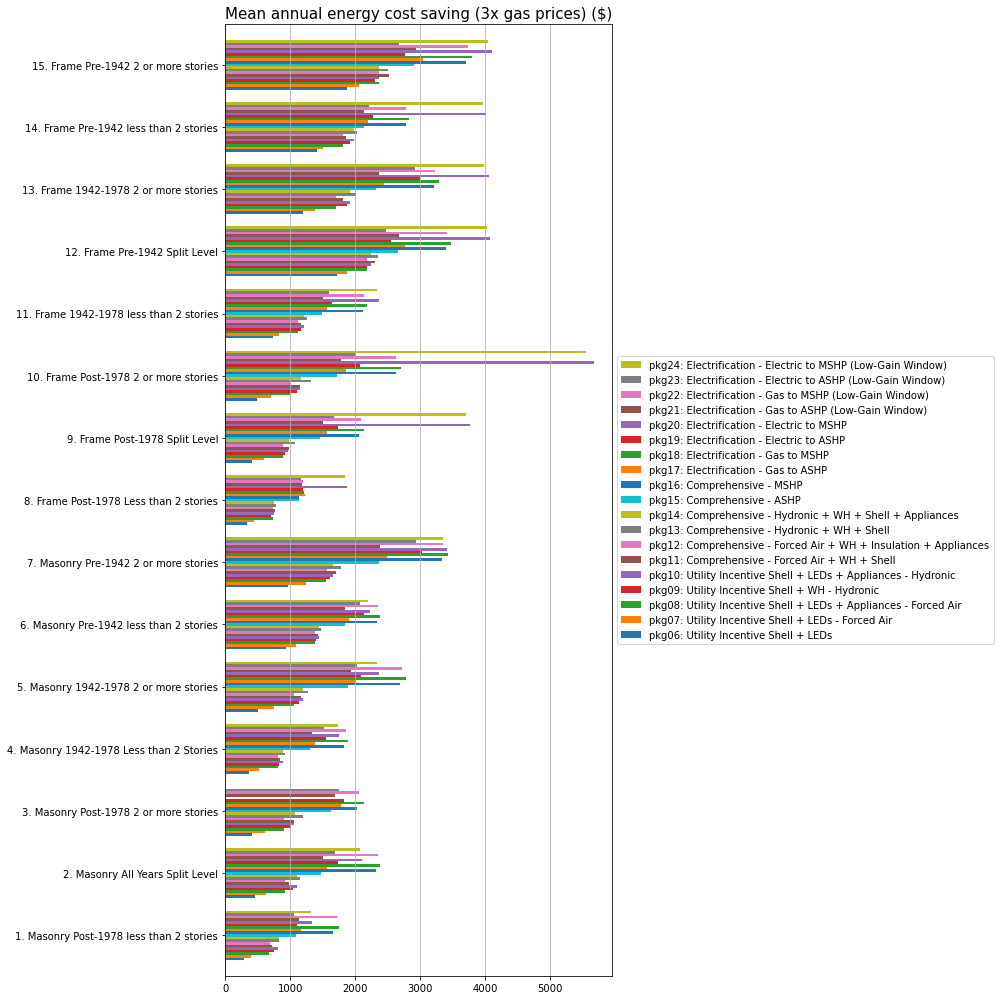

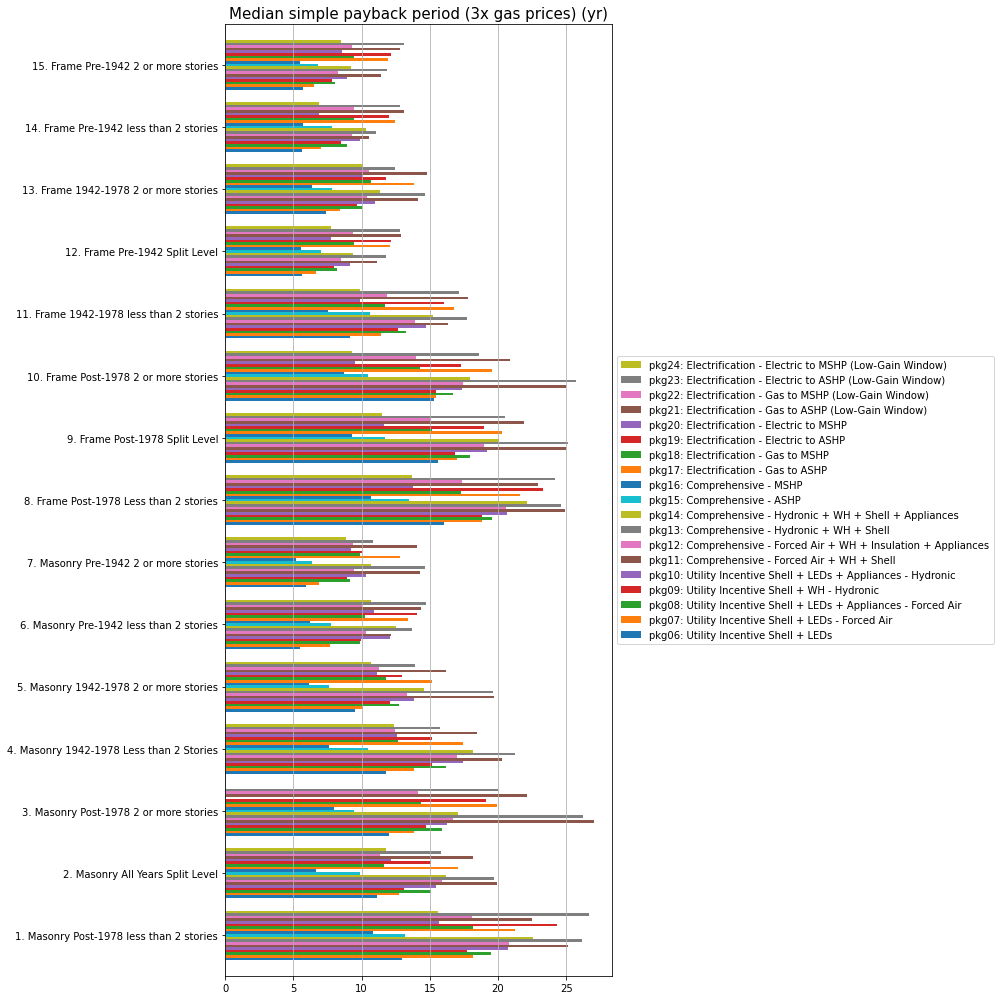

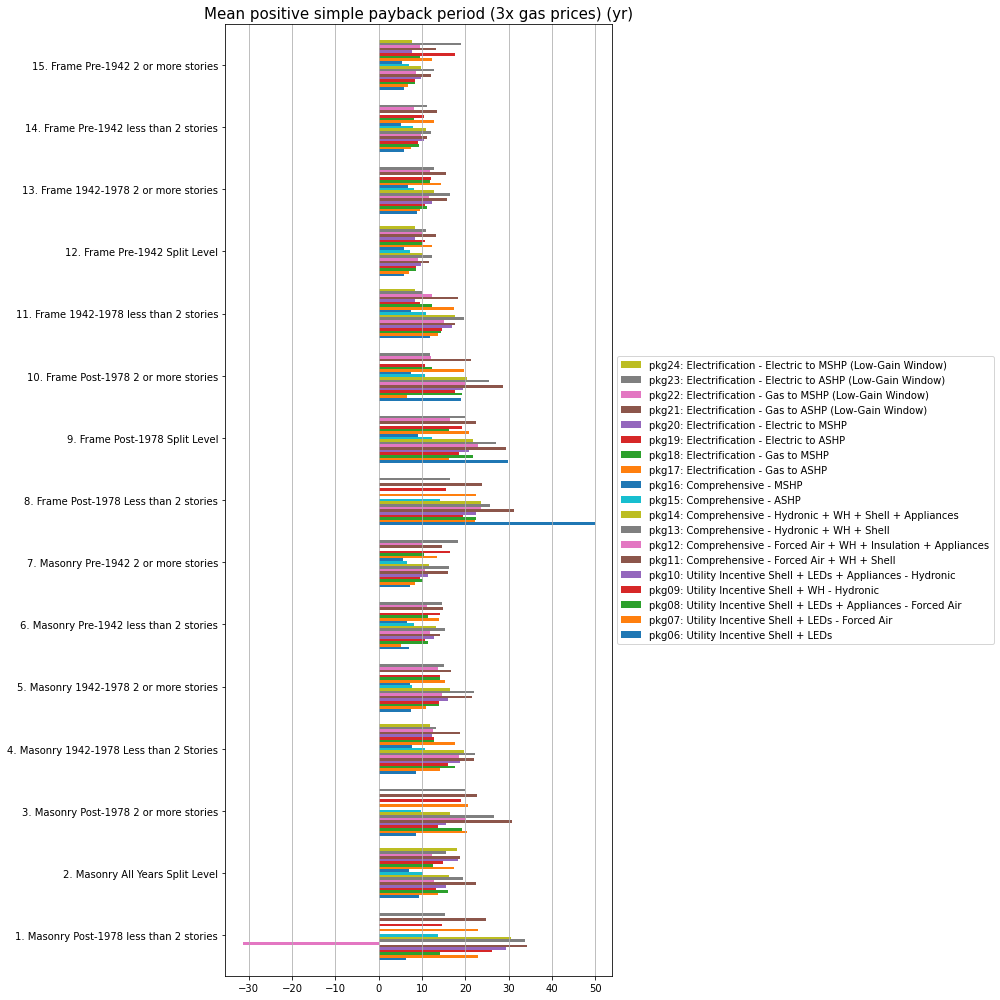

In [34]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
    'median_simple_payback': [-70, 70],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_pos_simple_payback': f'Mean positive simple payback period{title_ext} (yr)',
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPi = groups2.set_index(idx)[para_to_plot]
    xmin = UPi.replace([np.inf, -np.inf], np.nan).min().min()
    xmax = UPi.replace([np.inf, -np.inf], np.nan).max().max()

    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(14, 14))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg21)
    # Group 1A: (upg01-upg10) N=10
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(para_label, fontsize=15, y=1)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot in ['median_simple_payback', 'mean_pos_simple_payback']:
        if xmax >= 150:
            ax.set_xlim(0,150)
    
    plt.tight_layout()
    
    filename = f'{iter_path}-comparison_{para_to_plot}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [35]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']].copy()
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
groups_avg

Natural gas rate multiplier: 3


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg
0,mean_ann_energy_cost_saving,6,Utility Incentive Shell + LEDs,1197.110,731.930,488.450,330.940,417.970,1876.070,1722.480,1405.640,498.970,370.640,461.130,405.520,291.890,971.600,940.650,850.735385
1,mean_ann_energy_cost_saving,7,Utility Incentive Shell + LEDs - Forced Air,1387.470,829.820,706.820,450.180,591.970,2064.330,1879.790,1499.120,751.640,520.630,629.260,614.550,395.140,1247.080,1081.520,1032.842111
2,mean_ann_energy_cost_saving,8,Utility Incentive Shell + LEDs + Appliances - ...,1703.330,1121.670,1008.360,730.830,884.160,2366.930,2183.050,1803.750,1056.930,809.160,920.660,897.610,676.430,1555.760,1382.160,1328.687096
3,mean_ann_energy_cost_saving,9,Utility Incentive Shell + WH - Hydronic,1865.900,1164.530,1105.220,703.210,921.120,2310.780,2187.670,1922.860,1135.710,832.070,1049.350,1010.170,752.650,1606.400,1389.890,1348.706295
4,mean_ann_energy_cost_saving,10,Utility Incentive Shell + LEDs + Appliances - ...,1921.510,1213.820,1154.590,752.720,970.560,2361.260,2238.640,1974.870,1188.980,884.900,1102.240,1064.310,817.900,1658.910,1439.420,1399.933852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,pct_pos_simple_payback,20,Electrification - Electric to MSHP,0.000,7.692,0.000,0.000,0.000,4.000,6.250,0.000,0.000,4.478,2.885,NaN,0.000,0.000,0.000,1.338412
186,pct_pos_simple_payback,21,Electrification - Gas to ASHP (Low-Gain Window),81.568,81.252,82.456,81.408,81.099,81.413,81.332,83.632,82.635,81.048,80.976,82.947,82.316,81.739,82.917,81.595631
187,pct_pos_simple_payback,22,Electrification - Gas to MSHP (Low-Gain Window),14.655,14.557,5.556,0.000,20.690,13.004,13.967,12.775,16.667,13.918,14.399,0.000,0.000,14.828,13.426,10.337096
188,pct_pos_simple_payback,23,Electrification - Electric to ASHP (Low-Gain W...,5.000,4.110,2.500,4.000,4.615,5.556,3.125,7.143,3.846,2.381,1.293,3.704,3.846,5.000,14.286,4.759711


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results/plots/mean_values_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving (3x gas prices)...
    - Group1
Plotting Chicago avg: median_simple_payback (3x gas prices)...
    - Group1


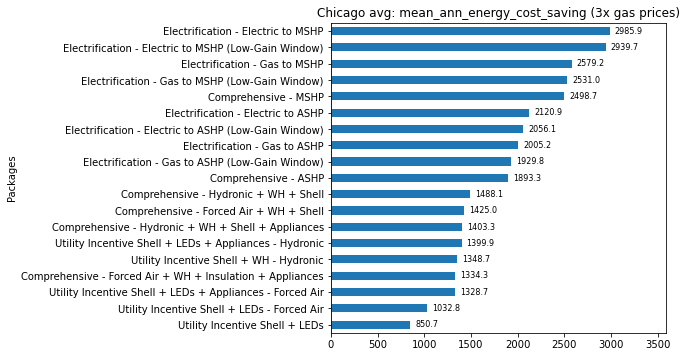

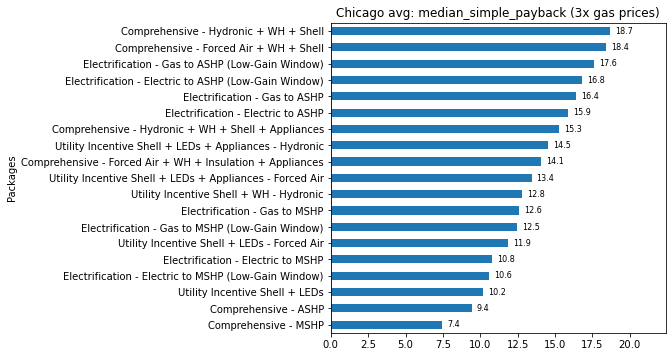

In [36]:
para_to_plot = 'Chicago avg' # <------

N_upgrades=19
upgrade_sets = {
    'Packages': range(6, N_upgrades+6),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.3. plot mean values for Chicago total stock 
Run cell below to load df for plots

In [37]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups_total = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'),
                         header=[0])
    
    print(f'"groups_total{fn_ext}" df loaded from file.')
    display(groups_total)
    

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results/plots/sum_values_chicago_total

Plotting Chicago total ann_gas_cost_saving (3x gas prices)...
    - Group1


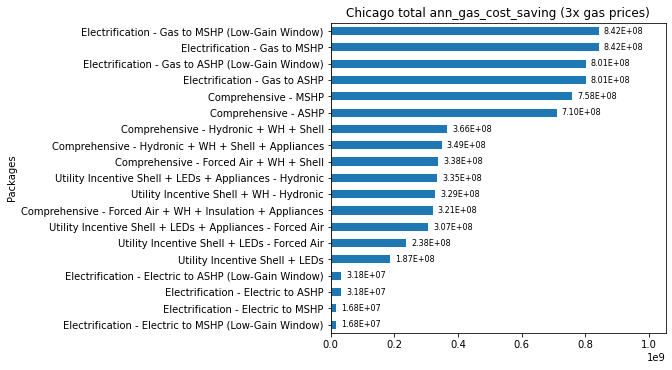

In [38]:
para_to_plot = 'Chicago total' # <------

N_upgrades = 19
upgrade_sets = {
    'Packages': range(6, N_upgrades+6),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path3 = os.path.join(plot_path, 'sum_values_chicago_total')
if not os.path.exists(plot_path3):
    os.mkdir(plot_path3)
print(f'plot dir: {plot_path3}\n')

if NG_rate_multiplier == 1:  
    metrics_to_plot = groups_total['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_gas_cost_saving']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot} {metric[5:]}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_total[(groups_total['metrics']==metric) & 
                              (groups_total['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.2E}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values.                      
                                            
        ax.margins(x=0.25)
        ax.axvline(x=0, linestyle='-', color='gray')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric[5:]}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path3, filename),
                    bbox_inches='tight')

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [39]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    all_proto_upgrades = pd.read_csv(os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['package_no'].unique().max()
    print(f'   total number of packages: {N_upgrades}')
    
    display(all_proto_upgrades)


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_02/processed results/plots/distribution_by_prototype

>> 1. plotting ann_energy_cost_saving_3x_gas_prices...
>> 2. plotting simple_payback_3x_gas_prices...


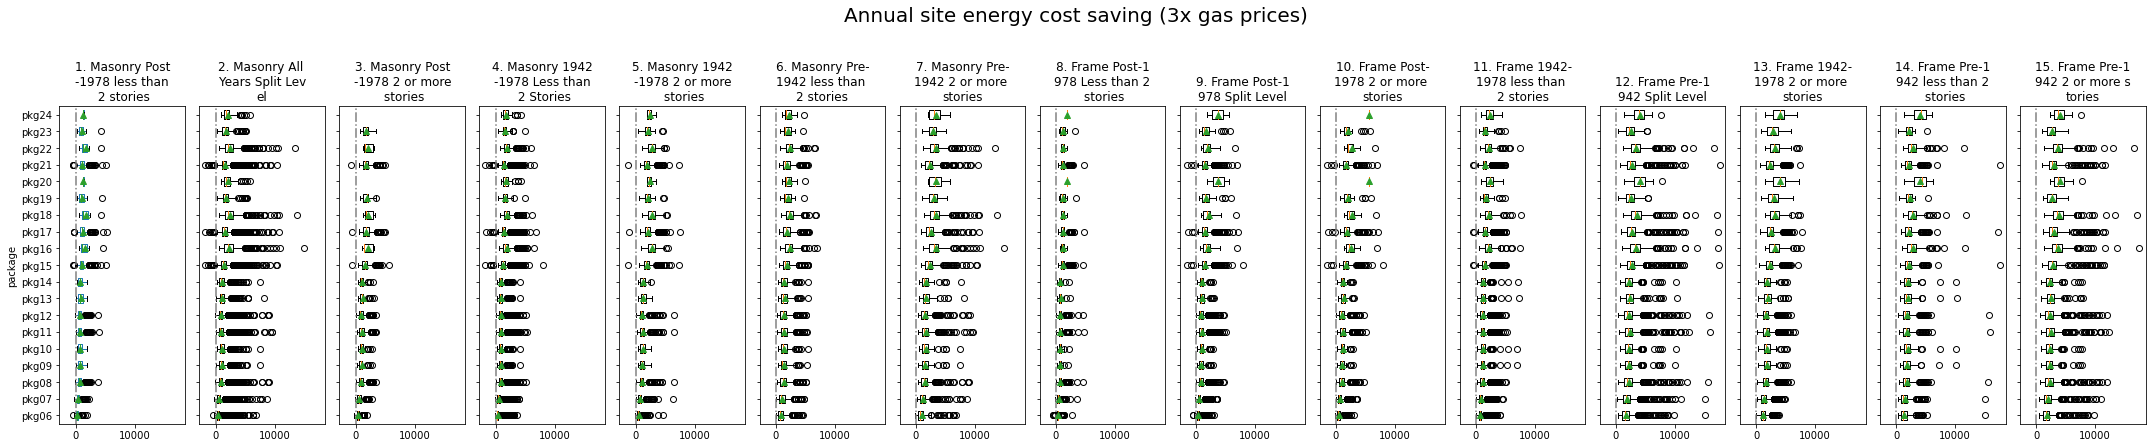

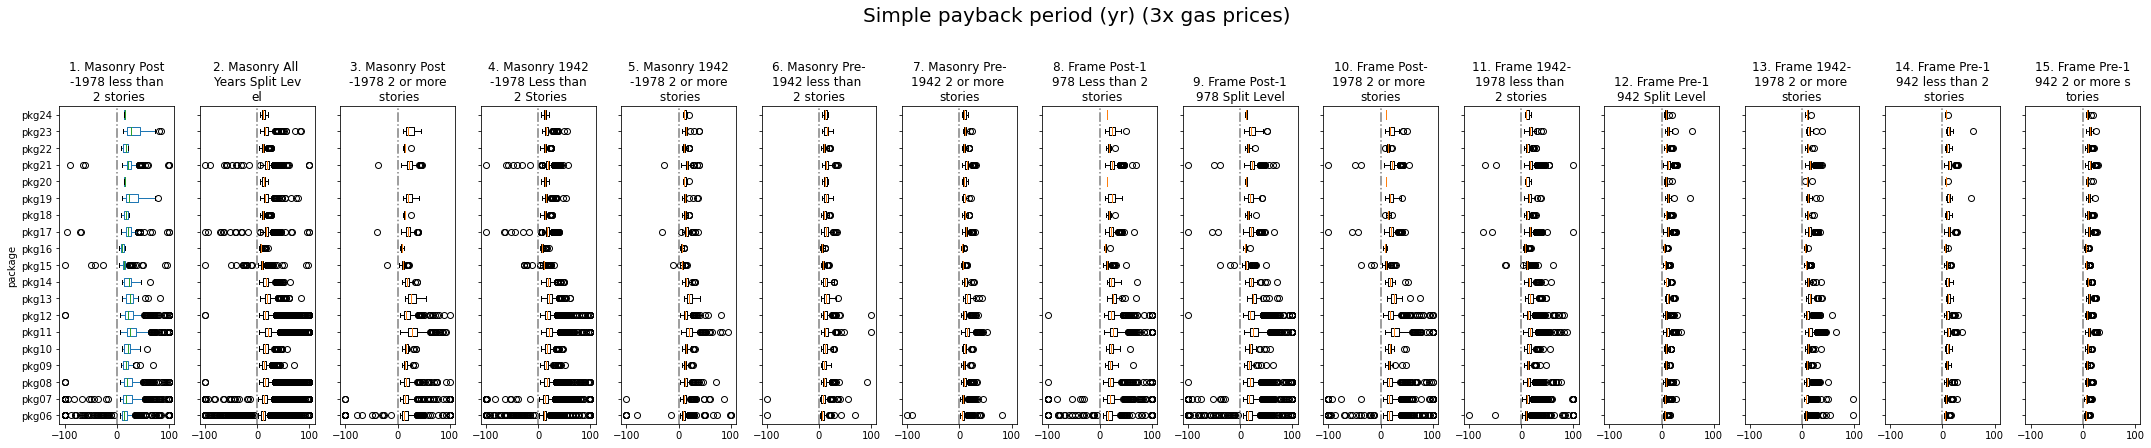

In [40]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

N_upgrades=19
cols_to_match = list(f'pkg{n:02d}' for n in range(6,N_upgrades+6))

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 6))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'package_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'package_no'] = 'pkg'+p['package_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='package_no')
        p = p.set_index([p.index, 'package_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')
        
        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1).reset_index(drop=True)
    
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('package')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
            
        ax.set_yticks(range(1, 1+N_upgrades))
        ax.set_yticklabels(cols_to_match)
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')
